Loaded dataset shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75



Columns and dtypes:
gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

Missing values per column:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Feature columns used:
['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

Numeric columns: []
Categorical columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

Training classifier (this may take a minute depending on hardware)...
Fitting 3 folds for each of 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Saved models to: C:\Users\sanja\Desktop\internship\models


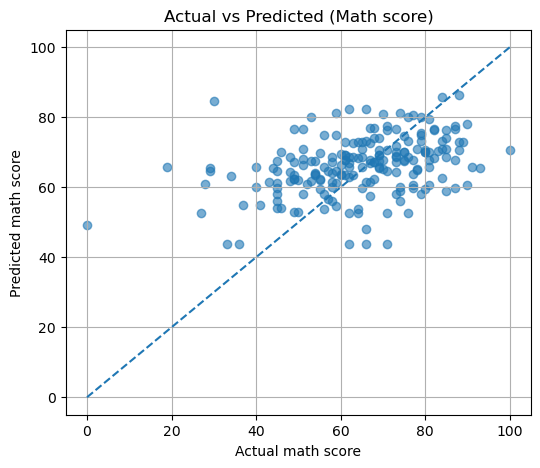

In [1]:
# Supervised learning on StudentsPerformance.csv
# Paste into a Jupyter notebook and run.

# 0) Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    mean_squared_error, r2_score
)
import joblib
import matplotlib.pyplot as plt

# 1) Load data (path from your upload)
DATA_PATH = "./StudentsPerformance.csv"
df = pd.read_csv(DATA_PATH)

print("Loaded dataset shape:", df.shape)
display(df.head())

# 2) Quick EDA
print("\nColumns and dtypes:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# 3) Create targets
# 3a) Classification target: "pass" if average of scores >= 60 (adjust threshold if you want)
score_cols = ["math score", "reading score", "writing score"]
df["avg_score"] = df[score_cols].mean(axis=1)
df["pass_60"] = (df["avg_score"] >= 60).astype(int)   # 1 = pass, 0 = fail

# 3b) Regression target example: predict "math score"
# (we'll treat math score as the regression target)

# 4) Feature selection: everything except the score columns + avg_score + targets
drop_cols = score_cols + ["avg_score"]
X = df.drop(columns=drop_cols + ["pass_60"])  # features for both tasks
# We'll create separate y for each task
y_clf = df["pass_60"]
y_reg = df["math score"]

print("\nFeature columns used:")
print(X.columns.tolist())

# 5) Identify numeric and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# 6) Preprocessing pipelines
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
], remainder="drop")

# 7) Train/test split (same split for both tasks for comparability)
RANDOM_STATE = 42
X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
    X, y_clf, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

# 8) Classification pipeline (Random Forest)
clf_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

# Quick hyperparameter grid (small for speed)
clf_param_grid = {
    "clf__n_estimators": [50, 150],
    "clf__max_depth": [None, 6, 12],
}

print("\nTraining classifier (this may take a minute depending on hardware)...")
clf_search = GridSearchCV(clf_pipeline, clf_param_grid, cv=3, n_jobs=-1, verbose=1)
clf_search.fit(X_train, y_clf_train)

print("\nBest classifier params:", clf_search.best_params_)
clf_best = clf_search.best_estimator_

# 9) Classification evaluation
y_clf_pred = clf_best.predict(X_test)
acc = accuracy_score(y_clf_test, y_clf_pred)
print(f"\nClassification Accuracy on test set: {acc:.4f}")
print("\nClassification report:")
print(classification_report(y_clf_test, y_clf_pred))

cm = confusion_matrix(y_clf_test, y_clf_pred)
print("Confusion matrix:\n", cm)
# Try ROC AUC if there are both classes present
if len(np.unique(y_clf_test)) == 2:
    y_proba = clf_best.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_clf_test, y_proba)
    print(f"ROC AUC: {auc:.4f}")

# 10) Regression pipeline (Random Forest Regressor)
reg_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("reg", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

reg_param_grid = {
    "reg__n_estimators": [50, 150],
    "reg__max_depth": [None, 6, 12],
}

print("\nTraining regressor (this may take a minute)...")
reg_search = GridSearchCV(reg_pipeline, reg_param_grid, cv=3, n_jobs=-1, verbose=1)
reg_search.fit(X_train, y_reg_train)

print("\nBest regressor params:", reg_search.best_params_)
reg_best = reg_search.best_estimator_

# 11) Regression evaluation
y_reg_pred = reg_best.predict(X_test)
rmse = mean_squared_error(y_reg_test, y_reg_pred, squared=False)
r2 = r2_score(y_reg_test, y_reg_pred)
print(f"\nRegression RMSE on test set: {rmse:.4f}")
print(f"Regression R^2 on test set: {r2:.4f}")


# 12) Save the trained models
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(clf_best, MODEL_DIR / "students_clf_pass60_rf.joblib")
joblib.dump(reg_best, MODEL_DIR / "students_reg_math_rf.joblib")
print(f"\nSaved models to: {MODEL_DIR.resolve()}")

# 13) Quick plots: actual vs predicted for regression
plt.figure(figsize=(6,5))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], "--")
plt.xlabel("Actual math score")
plt.ylabel("Predicted math score")
plt.title("Actual vs Predicted (Math score)")
plt.grid(True)
plt.show()


Shape: (167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200



Numeric columns and their descriptive stats:


,count,mean,std,min,25%,50%,75%,max
country,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


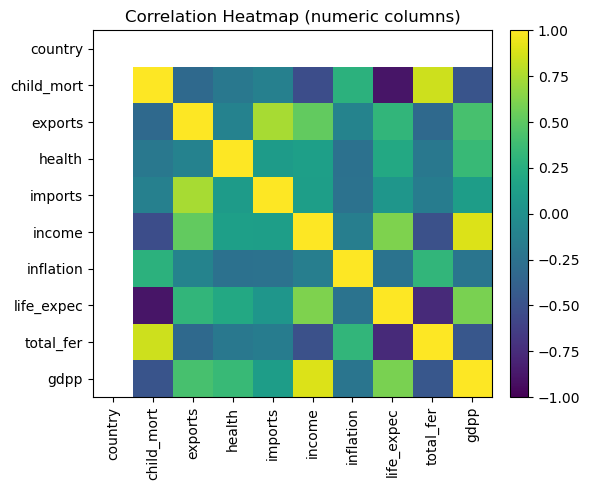

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child_mort,NaN,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,NaN,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,NaN,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,NaN,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,NaN,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,NaN,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,NaN,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,NaN,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,NaN,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000



Saved numeric-only cleaned data to: country_data_numeric_only.csv


In [2]:
# ================================================================
# SAFE ONE-CELL ANALYSIS FOR country_data (handles non-numeric cols)
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. LOAD DATASET (use the correct file name)
country_data = pd.read_csv("Country-data.csv")

# 2. SHOW BASIC INFO (brief)
print("Shape:", country_data.shape)
display(country_data.head())

# 3. TRY TO COERCE object columns that *look like numbers* into numeric types
#    This will turn non-numeric strings (e.g., country names) into NaN, leaving numeric columns intact.
country_data_converted = country_data.copy()
for col in country_data_converted.columns:
    if country_data_converted[col].dtype == object:
        # convert numeric-like strings to numeric, else NaN
        country_data_converted[col] = pd.to_numeric(country_data_converted[col], errors='coerce')

# 4. SELECT ONLY NUMERIC COLUMNS for analysis
numeric_df = country_data_converted.select_dtypes(include=[np.number])

if numeric_df.shape[1] == 0:
    print("\nNo numeric columns found after coercion — correlation heatmap skipped.")
else:
    # 5. FILL MISSING VALUES in numeric columns with median (safe for correlation)
    numeric_df_filled = numeric_df.fillna(numeric_df.median())

    # 6. DESCRIPTIVE STATS (numeric only)
    print("\nNumeric columns and their descriptive stats:")
    display(numeric_df_filled.describe().T)

    # 7. CORRELATION MATRIX
    corr = numeric_df_filled.corr()

    # 8. PLOT HEATMAP (simple matplotlib)
    plt.figure(figsize=(max(6, 0.5 * corr.shape[0]), max(5, 0.5 * corr.shape[0])))
    im = plt.imshow(corr, aspect='auto', cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    cols = corr.columns.tolist()
    plt.xticks(range(len(cols)), cols, rotation=90)
    plt.yticks(range(len(cols)), cols)
    plt.title("Correlation Heatmap (numeric columns)")
    plt.tight_layout()
    plt.show()

    # 9. SHOW CORRELATION TABLE HEAD (optional)
    display(corr)

# 10. SAVE cleaned numeric-only CSV if you want (optional)
numeric_df_filled = numeric_df_filled if 'numeric_df_filled' in globals() else pd.DataFrame()
if not numeric_df_filled.empty:
    numeric_df_filled.to_csv("country_data_numeric_only.csv", index=False)
    print("\nSaved numeric-only cleaned data to: country_data_numeric_only.csv")


✔ Dataset Loaded Successfully!
Shape: (10000, 10)


,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No



📌 DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB

📌 DESCRIPTIVE STATISTICS:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
College_ID,10000,100,CLG0062,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IQ,10000.0,NaN,NaN,NaN,99.4718,15.053101,41.0,89.0,99.0,110.0,158.0
Prev_Sem_Result,10000.0,NaN,NaN,NaN,7.535673,1.447519,5.0,6.29,7.56,8.79,10.0
CGPA,10000.0,NaN,NaN,NaN,7.532379,1.470141,4.54,6.29,7.55,8.77,10.46
Academic_Performance,10000.0,NaN,NaN,NaN,5.5464,2.873477,1.0,3.0,6.0,8.0,10.0
Internship_Experience,10000,2,No,6036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extra_Curricular_Score,10000.0,NaN,NaN,NaN,4.9709,3.160103,0.0,2.0,5.0,8.0,10.0
Communication_Skills,10000.0,NaN,NaN,NaN,5.5618,2.900866,1.0,3.0,6.0,8.0,10.0
Projects_Completed,10000.0,NaN,NaN,NaN,2.5134,1.715959,0.0,1.0,3.0,4.0,5.0
Placement,10000,2,No,8341,NaN,NaN,NaN,NaN,NaN,NaN,NaN



📌 MISSING VALUES:


College_ID                0
IQ                        0
Prev_Sem_Result           0
CGPA                      0
Academic_Performance      0
Internship_Experience     0
Extra_Curricular_Score    0
Communication_Skills      0
Projects_Completed        0
Placement                 0
dtype: int64


✔ Missing values handled!


,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


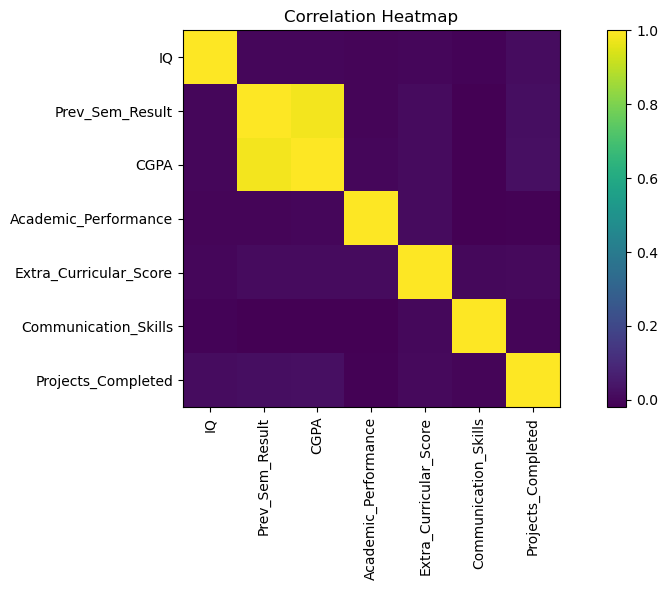


✔ Cleaned dataset saved as: college_student_placement_dataset_cleaned.csv


In [3]:
# ============================================================
# FULL ONE-CELL DATA ANALYSIS FOR college_student_placement_dataset.csv
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. LOAD DATASET
# ------------------------------------------------------------
df = pd.read_csv("college_student_placement_dataset.csv")

print("✔ Dataset Loaded Successfully!")
print("Shape:", df.shape)

# Preview
display(df.head())

# ------------------------------------------------------------
# 2. BASIC INFO
# ------------------------------------------------------------
print("\n📌 DATASET INFO:")
df.info()

# ------------------------------------------------------------
# 3. DESCRIPTIVE STATISTICS
# ------------------------------------------------------------
print("\n📌 DESCRIPTIVE STATISTICS:")
display(df.describe(include="all").T)

# ------------------------------------------------------------
# 4. CHECK MISSING VALUES
# ------------------------------------------------------------
print("\n📌 MISSING VALUES:")
display(df.isnull().sum())

# ------------------------------------------------------------
# 5. HANDLE MISSING VALUES (Safe Method)
#    - Numeric columns → fill with median
#    - Categorical columns → fill with mode
# ------------------------------------------------------------
df_clean = df.copy()

for col in df_clean.columns:
    if df_clean[col].dtype in ["int64", "float64"]:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    else:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

print("\n✔ Missing values handled!")
display(df_clean.head())

# ------------------------------------------------------------
# 6. CORRELATION HEATMAP (NUMERIC ONLY)
# ------------------------------------------------------------
numeric_df = df_clean.select_dtypes(include=[np.number])

if numeric_df.shape[1] > 1:
    plt.figure(figsize=(10, 6))
    plt.imshow(numeric_df.corr(), cmap='viridis')
    plt.colorbar()
    plt.title("Correlation Heatmap")
    plt.xticks(range(len(numeric_df.columns)), numeric_df.columns, rotation=90)
    plt.yticks(range(len(numeric_df.columns)), numeric_df.columns)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠ Not enough numeric columns for correlation heatmap!")

# ------------------------------------------------------------
# 7. SAVE CLEANED DATASET
# ------------------------------------------------------------
df_clean.to_csv("college_student_placement_dataset_cleaned.csv", index=False)
print("\n✔ Cleaned dataset saved as: college_student_placement_dataset_cleaned.csv")


✔ Dataset Loaded Successfully!
Shape: (5000, 12)


,Agent Name,Rating,Review Text,Delivery Time (min),Location,Order Type,Customer Feedback Type,Price Range,Discount Applied,Product Availability,Customer Service Rating,Order Accuracy
0,Zepto,4.5,Purpose boy job cup decision girl now get job ...,58,Delhi,Essentials,Neutral,High,Yes,Out of Stock,4,Incorrect
1,Zepto,2.1,Prevent production able both the box school wa...,25,Lucknow,Grocery,Negative,Low,No,Out of Stock,2,Correct
2,JioMart,4.5,Family station listen agreement more kitchen l...,54,Ahmedabad,Essentials,Neutral,Low,No,Out of Stock,3,Correct
3,JioMart,2.6,World north people area everything enter beyon...,22,Chennai,Essentials,Neutral,Low,Yes,In Stock,1,Incorrect
4,Zepto,3.6,Hand way yourself tax whether sister anyone ef...,34,Pune,Pharmacy,Positive,High,No,In Stock,2,Incorrect



📌 DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Agent Name               5000 non-null   object 
 1   Rating                   5000 non-null   float64
 2   Review Text              5000 non-null   object 
 3   Delivery Time (min)      5000 non-null   int64  
 4   Location                 5000 non-null   object 
 5   Order Type               5000 non-null   object 
 6   Customer Feedback Type   5000 non-null   object 
 7   Price Range              5000 non-null   object 
 8   Discount Applied         5000 non-null   object 
 9   Product Availability     5000 non-null   object 
 10  Customer Service Rating  5000 non-null   int64  
 11  Order Accuracy           5000 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 468.9+ KB

📌 DESCRIPTIVE STATISTICS:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Agent Name,5000,4,Zepto,1282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,5000.0,NaN,NaN,NaN,3.0029,1.15214,1.0,2.0,3.0,4.0,5.0
Review Text,5000,5000,Purpose boy job cup decision girl now get job ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Delivery Time (min),5000.0,NaN,NaN,NaN,34.9624,14.789656,10.0,22.0,35.0,48.0,60.0
Location,5000,10,Kolkata,517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order Type,5000,5,Electronics,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Feedback Type,5000,3,Negative,1727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price Range,5000,3,High,1696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Discount Applied,5000,2,Yes,2537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product Availability,5000,2,Out of Stock,2503,NaN,NaN,NaN,NaN,NaN,NaN,NaN



📌 MISSING VALUES:


Agent Name                 0
Rating                     0
Review Text                0
Delivery Time (min)        0
Location                   0
Order Type                 0
Customer Feedback Type     0
Price Range                0
Discount Applied           0
Product Availability       0
Customer Service Rating    0
Order Accuracy             0
dtype: int64


✔ Missing values handled!


,Agent Name,Rating,Review Text,Delivery Time (min),Location,Order Type,Customer Feedback Type,Price Range,Discount Applied,Product Availability,Customer Service Rating,Order Accuracy
0,Zepto,4.5,Purpose boy job cup decision girl now get job ...,58,Delhi,Essentials,Neutral,High,Yes,Out of Stock,4,Incorrect
1,Zepto,2.1,Prevent production able both the box school wa...,25,Lucknow,Grocery,Negative,Low,No,Out of Stock,2,Correct
2,JioMart,4.5,Family station listen agreement more kitchen l...,54,Ahmedabad,Essentials,Neutral,Low,No,Out of Stock,3,Correct
3,JioMart,2.6,World north people area everything enter beyon...,22,Chennai,Essentials,Neutral,Low,Yes,In Stock,1,Incorrect
4,Zepto,3.6,Hand way yourself tax whether sister anyone ef...,34,Pune,Pharmacy,Positive,High,No,In Stock,2,Incorrect


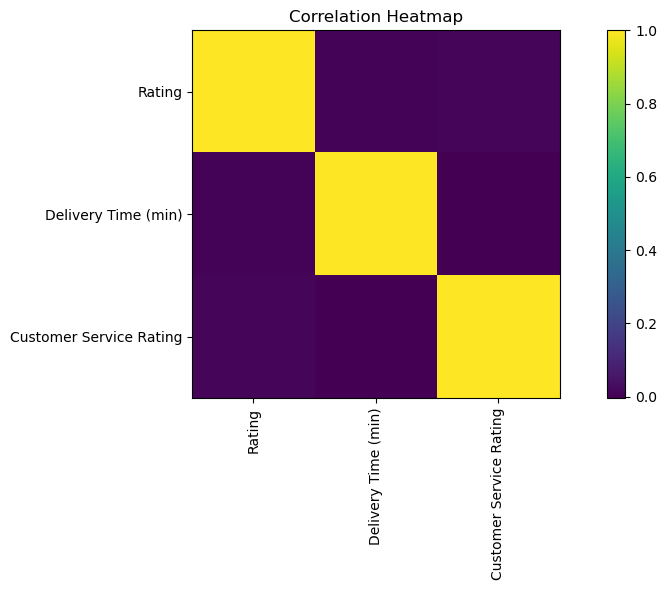


✔ Cleaned dataset saved as: Fast_Delivery_Agent_Reviews_Cleaned.csv


In [4]:
# =====================================================================
# FULL ONE-CELL DATA ANALYSIS FOR: Fast Delivery Agent Reviews.csv
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. LOAD DATASET
# ------------------------------------------------------------
df = pd.read_csv("Fast Delivery Agent Reviews.csv")

print("✔ Dataset Loaded Successfully!")
print("Shape:", df.shape)

# Preview dataset
display(df.head())

# ------------------------------------------------------------
# 2. DATASET INFO
# ------------------------------------------------------------
print("\n📌 DATASET INFO:")
df.info()

# ------------------------------------------------------------
# 3. DESCRIPTIVE STATISTICS
# ------------------------------------------------------------
print("\n📌 DESCRIPTIVE STATISTICS:")
display(df.describe(include='all').T)

# ------------------------------------------------------------
# 4. MISSING VALUES CHECK
# ------------------------------------------------------------
print("\n📌 MISSING VALUES:")
display(df.isnull().sum())

# ------------------------------------------------------------
# 5. HANDLE MISSING VALUES
# ------------------------------------------------------------
df_clean = df.copy()

for col in df_clean.columns:
    if df_clean[col].dtype in ["int64", "float64"]:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    else:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

print("\n✔ Missing values handled!")
display(df_clean.head())

# ------------------------------------------------------------
# 6. CORRELATION HEATMAP (NUMERIC ONLY)
# ------------------------------------------------------------
numeric_df = df_clean.select_dtypes(include=[np.number])

if numeric_df.shape[1] > 1:
    plt.figure(figsize=(10, 6))
    plt.imshow(numeric_df.corr(), cmap='viridis')
    plt.colorbar()
    plt.title("Correlation Heatmap")
    plt.xticks(range(len(numeric_df.columns)), numeric_df.columns, rotation=90)
    plt.yticks(range(len(numeric_df.columns)), numeric_df.columns)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠ Not enough numeric columns for correlation heatmap!")

# ------------------------------------------------------------
# 7. SAVE CLEANED DATASET
# ------------------------------------------------------------
df_clean.to_csv("Fast_Delivery_Agent_Reviews_Cleaned.csv", index=False)
print("\n✔ Cleaned dataset saved as: Fast_Delivery_Agent_Reviews_Cleaned.csv")


Using feature names (count=17):
['cat__gender_female', 'cat__gender_male', 'cat__race/ethnicity_group A', 'cat__race/ethnicity_group B', 'cat__race/ethnicity_group C', 'cat__race/ethnicity_group D', 'cat__race/ethnicity_group E', "cat__parental level of education_associate's degree", "cat__parental level of education_bachelor's degree", 'cat__parental level of education_high school', "cat__parental level of education_master's degree", 'cat__parental level of education_some college', 'cat__parental level of education_some high school', 'cat__lunch_free/reduced', 'cat__lunch_standard', 'cat__test preparation course_completed', 'cat__test preparation course_none']

=== 5.2 Permutation feature importance ===
Computing permutation importance for classifier (may take a moment)...

Top classifier permutation importances:
                        feature  importance_mean  importance_std
0  cat__race/ethnicity_group B         0.005000        0.023058
1             cat__gender_male        -0.0081

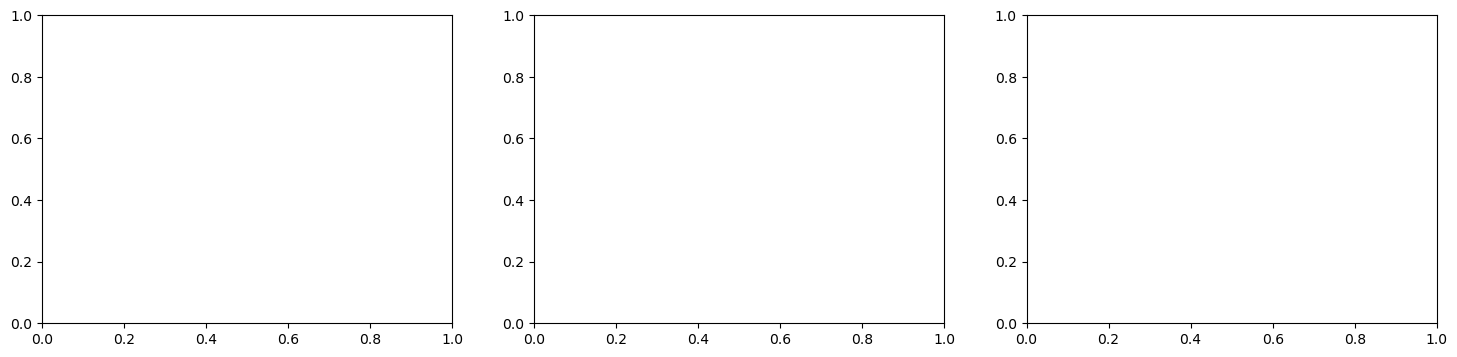

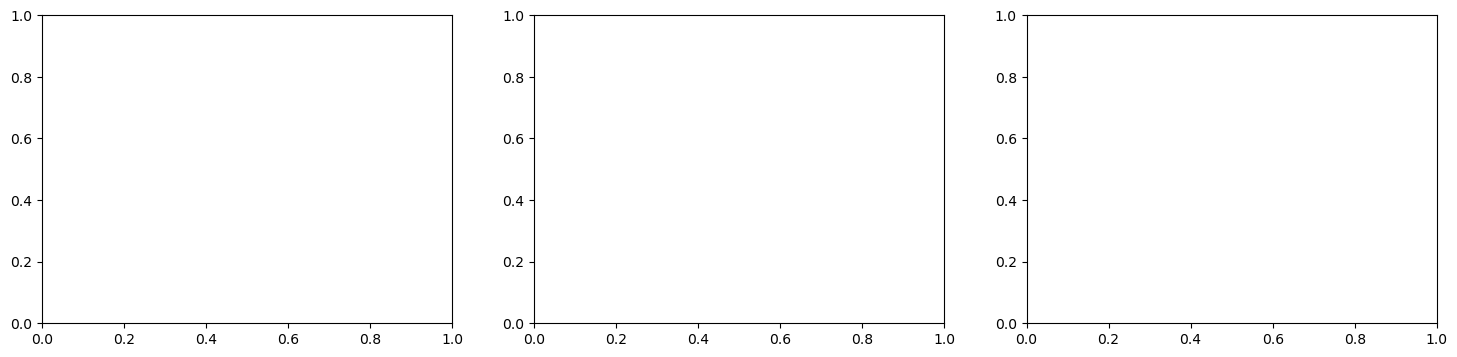

In [5]:
# ==========================================
# 5. INSPECTION: PDP, ICE, Permutation Importance
# Paste & run after previous cells (requires clf_best, reg_best, X_test, y_clf_test, y_reg_test)
# ==========================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import (
    permutation_importance,
    PartialDependenceDisplay
)
from sklearn.inspection import DecisionBoundaryDisplay  # optional helper in some sklearn versions

# Quick checks
assert 'clf_best' in globals() and 'reg_best' in globals(), "Run the supervised training cell first (clf_best/reg_best required)."
assert 'X_test' in globals(), "X_test not found. Make sure to run the earlier cells."

# Helper: get feature names out of ColumnTransformer (works for modern sklearn versions)
def get_feature_names_from_preprocessor(preprocessor, input_features):
    """
    Try to obtain feature names from ColumnTransformer + OneHotEncoders.
    If it fails, fall back to the input_features list.
    """
    try:
        # If preprocessor is a ColumnTransformer instance
        # Many versions accept get_feature_names_out(input_features)
        names = preprocessor.get_feature_names_out(input_features)
        return list(names)
    except Exception:
        # Try for pipeline embedded preprocessor (e.g., clf_best.named_steps['preproc'])
        try:
            names = preprocessor.get_feature_names_out()
            return list(names)
        except Exception:
            # fallback to input_features
            return list(input_features)

# Get input feature names (X is original DataFrame of features)
if isinstance(X, pd.DataFrame):
    input_feature_names = X.columns.tolist()
else:
    # If X is an array, we don't have feature names
    input_feature_names = [f"f{i}" for i in range(X.shape[1])]

# Try to extract preprocessor used inside classifier/regressor pipeline
def extract_preprocessor_from_pipeline(pipeline_obj):
    if hasattr(pipeline_obj, "named_steps") and "preproc" in pipeline_obj.named_steps:
        return pipeline_obj.named_steps["preproc"]
    # common fallback: step named 'preprocessor' or 'preproc'
    for name in ["preprocessor", "preproc"]:
        if hasattr(pipeline_obj, "named_steps") and name in pipeline_obj.named_steps:
            return pipeline_obj.named_steps[name]
    # otherwise maybe pipeline_obj itself is a preprocessor
    return None

clf_preproc = extract_preprocessor_from_pipeline(clf_best)
reg_preproc = extract_preprocessor_from_pipeline(reg_best)

# Prefer preprocessor from classifier, else regressor; else global preprocessor variable if present
effective_preproc = clf_preproc or reg_preproc or (preprocessor if 'preprocessor' in globals() else None)

feature_names = get_feature_names_from_preprocessor(effective_preproc, input_feature_names) if effective_preproc is not None else input_feature_names
print("Using feature names (count={}):\n{}".format(len(feature_names), feature_names[:30]))

# -----------------------
# 5.2 Permutation Importance
# -----------------------
print("\n=== 5.2 Permutation feature importance ===")

# Classification permutation importance (on the test set)
try:
    print("Computing permutation importance for classifier (may take a moment)...")
    r_clf = permutation_importance(clf_best, X_test, y_clf_test, n_repeats=30, random_state=42, n_jobs=-1, scoring="accuracy")
    imp_df_clf = pd.DataFrame({
        "feature": feature_names[: r_clf.importances_mean.shape[0]],
        "importance_mean": r_clf.importances_mean,
        "importance_std": r_clf.importances_std
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)
    print("\nTop classifier permutation importances:\n", imp_df_clf.head(10))
except Exception as e:
    print("Classifier permutation importance failed:", type(e).__name__, e)
    imp_df_clf = None

# Regression permutation importance (on the test set)
try:
    print("\nComputing permutation importance for regressor (may take a moment)...")
    r_reg = permutation_importance(reg_best, X_test, y_reg_test, n_repeats=30, random_state=42, n_jobs=-1, scoring="neg_root_mean_squared_error")
    imp_df_reg = pd.DataFrame({
        "feature": feature_names[: r_reg.importances_mean.shape[0]],
        "importance_mean": -r_reg.importances_mean,  # negate because scoring was negative RMSE (higher is better)
        "importance_std": r_reg.importances_std
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)
    print("\nTop regressor permutation importances (by harm when permuted):\n", imp_df_reg.head(10))
except Exception as e:
    print("Regressor permutation importance failed:", type(e).__name__, e)
    imp_df_reg = None

# -----------------------
# 5.1 Partial Dependence & ICE
# -----------------------
print("\n=== 5.1 Partial Dependence (PDP) and ICE plots ===")

# Select top features for PDP/ICE plotting:
def top_features_from_importances(imp_df, k=3):
    if imp_df is None or imp_df.shape[0] == 0:
        # fallback: use first k features
        return feature_names[:k]
    return imp_df["feature"].values[:k].tolist()

# Prefer classifier's top features for PDP on classification, and regressor for regression
top_clf_feats = top_features_from_importances(imp_df_clf, k=3)
top_reg_feats = top_features_from_importances(imp_df_reg, k=3)

print("Top classifier features:", top_clf_feats)
print("Top regressor features:", top_reg_feats)

# For PartialDependenceDisplay.from_estimator we need the estimator and the raw X
# Use pipeline (clf_best/reg_best) and original X_test (not scaled) so pipeline applies preprocessing
try:
    # PDP for classifier on top features
    if len(top_clf_feats) > 0:
        print("\nPlotting PDP (classifier) for top features:", top_clf_feats)
        fig, ax = plt.subplots(1, len(top_clf_feats), figsize=(6 * len(top_clf_feats), 4))
        if len(top_clf_feats) == 1:
            ax = [ax]
        PartialDependenceDisplay.from_estimator(clf_best, X_test, features=top_clf_feats, kind="average", ax=ax)
        plt.suptitle("Partial Dependence (Classifier) - averaged PDPs")
        plt.tight_layout()
        plt.show()

        # ICE (individual conditional expectation) for the first of these features
        print("\nPlotting ICE (classifier) for feature:", top_clf_feats[0])
        fig, ax = plt.subplots(figsize=(6,5))
        PartialDependenceDisplay.from_estimator(clf_best, X_test, features=[top_clf_feats[0]], kind="individual", subsample=100, ax=ax)
        plt.title(f"ICE plot (Classifier) for {top_clf_feats[0]}")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("PDP/ICE (classifier) plotting failed:", type(e).__name__, e)

try:
    # PDP for regressor on top features
    if len(top_reg_feats) > 0:
        print("\nPlotting PDP (regressor) for top features:", top_reg_feats)
        fig, ax = plt.subplots(1, len(top_reg_feats), figsize=(6 * len(top_reg_feats), 4))
        if len(top_reg_feats) == 1:
            ax = [ax]
        PartialDependenceDisplay.from_estimator(reg_best, X_test, features=top_reg_feats, kind="average", ax=ax)
        plt.suptitle("Partial Dependence (Regressor) - averaged PDPs")
        plt.tight_layout()
        plt.show()

        # ICE for the first regressor feature
        print("\nPlotting ICE (regressor) for feature:", top_reg_feats[0])
        fig, ax = plt.subplots(figsize=(6,5))
        PartialDependenceDisplay.from_estimator(reg_best, X_test, features=[top_reg_feats[0]], kind="individual", subsample=100, ax=ax)
        plt.title(f"ICE plot (Regressor) for {top_reg_feats[0]}")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("PDP/ICE (regressor) plotting failed:", type(e).__name__, e)


# -----------------------
# 5.2 Notes on interpretation
# -----------------------
print("\n=== NOTES on interpretation ===")
print("- Permutation importance measures how much model score decreases when a single feature is permuted.")
print("- PDP shows the average marginal effect of a feature on predictions; ICE shows per-sample curves.")
print("- PDP/importance can be misleading for strongly correlated features: permuting one breaks correlations and can inflate importance.")
print("- For correlated features consider conditional PDPs, SHAP, or grouping correlated features before interpretation.")
print("- Use ICE plots to detect heterogeneous effects across samples (non-additivity).")

# Optionally display and save importance tables to disk
try:
    if imp_df_clf is not None:
        imp_df_clf.to_csv("models/permutation_importance_classifier.csv", index=False)
    if imp_df_reg is not None:
        imp_df_reg.to_csv("models/permutation_importance_regressor.csv", index=False)
    print("\nSaved permutation importances to models/ (CSV).")
except Exception as e:
    print("Saving importances failed:", e)

print("\nInspection module completed.")


Dataset Loaded Successfully!
Shape: (150, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa



DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB

DESCRIPTIVE STATISTICS:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,150.0,NaN,NaN,NaN,75.5,43.445368,1.0,38.25,75.5,112.75,150.0
SepalLengthCm,150.0,NaN,NaN,NaN,5.843333,0.828066,4.3,5.1,5.8,6.4,7.9
SepalWidthCm,150.0,NaN,NaN,NaN,3.054,0.433594,2.0,2.8,3.0,3.3,4.4
PetalLengthCm,150.0,NaN,NaN,NaN,3.758667,1.76442,1.0,1.6,4.35,5.1,6.9
PetalWidthCm,150.0,NaN,NaN,NaN,1.198667,0.763161,0.1,0.3,1.3,1.8,2.5
Species,150,3,Iris-setosa,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN



MISSING VALUES:
Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Encoded Species (0,1,2):


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0



Train/Test Split Complete
Training Shape: (120, 4)
Testing Shape: (30, 4)

Model Training Completed

Model Accuracy: 100.00%


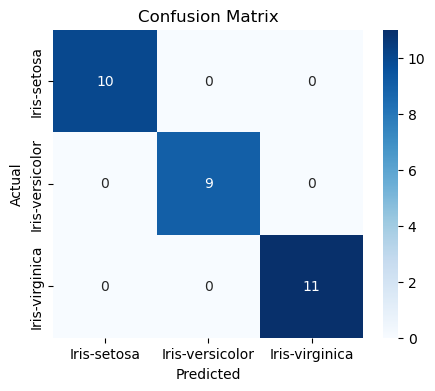


Cleaned dataset saved as Iris_cleaned.csv


In [6]:
# =====================================================================
# ONE-CELL IRIS DATASET ANALYSIS + ML MODEL
# Dataset name: Iris.csv
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. LOAD DATASET
df = pd.read_csv("Iris.csv")
print("Dataset Loaded Successfully!")
print("Shape:", df.shape)
display(df.head())

# 2. DATASET INFO
print("\nDATASET INFO:")
df.info()

# 3. DESCRIPTIVE STATISTICS
print("\nDESCRIPTIVE STATISTICS:")
display(df.describe(include="all").T)

# 4. CHECK MISSING VALUES
print("\nMISSING VALUES:")
print(df.isnull().sum())

# 5. ENCODE SPECIES COLUMN
le = LabelEncoder()
df["Species"] = le.fit_transform(df["Species"])
print("\nEncoded Species (0,1,2):")
display(df.head())

# 6. TRAIN/TEST SPLIT
X = df.drop(["Species", "Id"], axis=1) if "Id" in df.columns else df.drop("Species", axis=1)
y = df["Species"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain/Test Split Complete")
print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

# 7. TRAIN LOGISTIC REGRESSION MODEL
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
print("\nModel Training Completed")

# 8. MODEL PREDICTION & ACCURACY
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {acc*100:.2f}%")

# 9. CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 10. SAVE CLEANED DATASET
df.to_csv("Iris_cleaned.csv", index=False)
print("\nCleaned dataset saved as Iris_cleaned.csv")


In [7]:
# ================================================================
# ONE CELL NOTEBOOK: Dataset transformations demo (FULL, corrected)
# Target file: HR-Employee-Attrition.csv (or first CSV in working dir)
#
# - Loads dataset
# - Shows short EDA
# - Demonstrates transformers & composition:
#    Pipelines, ColumnTransformer, FeatureUnion, custom transformer
#    Imputation, scaling, PowerTransformer, Normalizer, OneHot/Ordinal encoding
#    PolynomialFeatures, RandomProjection, PCA, Nystroem (if available)
#    Pairwise kernels (cosine, linear, polynomial, rbf)
#    LabelEncoder & LabelBinarizer (fixed usage)
# - Uses safe fallbacks for sklearn version differences
# - Uses small subsets for expensive ops
# - Saves cleaned sample and metadata
# ================================================================

import os, warnings, json, textwrap
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pprint import pprint
print("Starting dataset-transformations demo...")

# ---------------------------
# Auto-detect CSV file
# ---------------------------
preferred_name = "HR-Employee-Attrition.csv"
csvs = [f for f in os.listdir() if f.lower().endswith(".csv")]
if not csvs:
    raise FileNotFoundError("No CSV files found in working directory. Upload 'HR-Employee-Attrition.csv' and re-run.")
fname = preferred_name if preferred_name in csvs else csvs[0]
print(f"Loading CSV: {fname}\n")

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv(fname)
print("Loaded dataset shape:", df.shape)
display(df.head())

# ---------------------------
# Short embedded documentation (7.x summary)
# ---------------------------
doc = """
SECTION: Dataset transformations (short)
- Transformers implement fit/transform (or fit_transform). Use Pipelines to chain them.
- ColumnTransformer handles heterogeneous columns. FeatureUnion merges parallel features.
- Common transforms: impute, scale, power transform, normalize, encode, polynomial features.
- Dimensionality reduction: PCA, Random Projection, Feature Agglomeration.
- Kernel approximations: Nystroem, RBFSampler; Pairwise kernels: cosine, linear, polynomial, RBF.
- Target transforms: LabelEncoder and LabelBinarizer for y.
"""
print(textwrap.dedent(doc))

# ---------------------------
# Quick EDA
# ---------------------------
print("\n--- Quick EDA ---")
meta_df = pd.DataFrame({"dtype": df.dtypes.astype(str),
                        "missing": df.isnull().sum(),
                        "unique": df.nunique(dropna=False)})
display(meta_df)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"\nNumeric cols ({len(num_cols)}): {num_cols[:10]}{'...' if len(num_cols)>10 else ''}")
print(f"Categorical cols ({len(cat_cols)}): {cat_cols[:10]}{'...' if len(cat_cols)>10 else ''}")

# ---------------------------
# Helpers: robust OneHotEncoder factory (supporting older/newer sklearn)
# ---------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

def make_onehot(**kwargs):
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse=False, **kwargs)
    except TypeError:
        try:
            return OneHotEncoder(handle_unknown="ignore", sparse_output=False, **kwargs)
        except TypeError:
            return OneHotEncoder(handle_unknown="ignore", **kwargs)

# ---------------------------
# Custom transformer example (tenure buckets)
# ---------------------------
class TenureBucketTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="YearsAtCompany"):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # accept DataFrame
        if hasattr(X, "loc"):
            col = pd.to_numeric(X[self.column].fillna(0), errors="coerce").fillna(0).values
        else:
            raise ValueError("TenureBucketTransformer expects a DataFrame with column: " + self.column)
        buckets = np.zeros_like(col, dtype=int)
        buckets[(col>=3)&(col<=5)] = 1
        buckets[(col>=6)&(col<=10)] = 2
        buckets[col>10] = 3
        return buckets.reshape(-1,1)

# ---------------------------
# Build safe preprocessing pipelines
# ---------------------------
from sklearn.preprocessing import FunctionTransformer

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),           # univariate imputation
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),  # non-linear transform
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_onehot())
])

# Use limited column subsets for demo to keep runtime small
safe_num_cols = num_cols[:10]
safe_cat_cols = cat_cols[:6]

# Build ColumnTransformer; handle optional tenure bucket if column exists
transformers = []
if safe_num_cols:
    transformers.append(("num", numeric_pipeline, safe_num_cols))
if safe_cat_cols:
    transformers.append(("cat", categorical_pipeline, safe_cat_cols))
if "YearsAtCompany" in df.columns:
    # transform tenure into buckets then one-hot
    transformers.append(("tenure_bucket", Pipeline([("ten", TenureBucketTransformer(column="YearsAtCompany")), ("ohe_tb", make_onehot())]), ["YearsAtCompany"]))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0)
print("\nPreprocessor configured (limited column subsets).")

# ---------------------------
# FeatureUnion: composite feature spaces
# ---------------------------
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA

poly_pipe = Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)), ("scale2", StandardScaler())])
rp = GaussianRandomProjection(n_components=min(5, max(1, len(safe_num_cols))), random_state=42)

from sklearn.pipeline import make_pipeline
# Create a composite pipeline that extracts numeric subset then applies union
composite_pipeline = Pipeline([
    ("select_numeric", FunctionTransformer(lambda X: X[safe_num_cols].to_numpy() if hasattr(X, "loc") else np.asarray(X), validate=False)),
    ("union", FeatureUnion(transformer_list=[
        ("numeric_raw", numeric_pipeline),
        ("poly", poly_pipe),
        ("rp", rp)
    ], n_jobs=1))
])
print("FeatureUnion composite pipeline created.")

# ---------------------------
# Kernel approximation availability
# ---------------------------
try:
    from sklearn.kernel_approximation import Nystroem, RBFSampler
    nystroem = Nystroem(kernel="rbf", n_components=min(50, max(10, len(safe_num_cols))), random_state=42)
    rbf_sampler = RBFSampler(gamma=1.0, n_components=min(50, max(10, len(safe_num_cols))), random_state=42)
    kernel_available = True
    print("Kernel approximation tools (Nystroem/RBFSampler) available.")
except Exception:
    nystroem = None
    rbf_sampler = None
    kernel_available = False
    print("Kernel approximation not available in this environment (skipping related demos).")

# ---------------------------
# Pairwise metrics
# ---------------------------
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel, polynomial_kernel, rbf_kernel
print("Pairwise metric functions ready (cosine, linear, polynomial, rbf).")

# ---------------------------
# Target detection and LABEL transforms (fixed usage of LabelBinarizer)
# ---------------------------
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

target_col = None
for cand in ["Attrition","attrition","LEFT","Left"]:
    if cand in df.columns:
        target_col = cand
        break

if target_col is not None:
    y_raw = df[target_col].copy()
    print(f"\nDetected target column: '{target_col}' (value counts):")
    print(y_raw.value_counts(dropna=False).head(10))

    # Label encoding
    le = LabelEncoder()
    y_enc = le.fit_transform(y_raw.astype(str))

    # Label binarization: fit first, then inspect y_type_
    lb = LabelBinarizer()
    lb.fit(y_raw.astype(str))
    if getattr(lb, "y_type_", None) != "multiclass":
        y_bin = lb.transform(y_raw.astype(str)).ravel()
    else:
        y_bin = lb.transform(y_raw.astype(str))
    print("LabelEncoder classes:", le.classes_)
    print("LabelBinarizer y_type_:", lb.y_type_)
else:
    print("\nNo common target column detected (Attrition). Supervised demo will be skipped.")
    y_enc = None
    y_bin = None

# ---------------------------
# Supervised demo (if target exists) using limited columns for speed
# ---------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

if target_col is not None:
    mask = df[target_col].notnull()
    X_full = df.loc[mask].reset_index(drop=True)
    y_full = y_enc[mask.values] if isinstance(y_enc, np.ndarray) else pd.Series(y_enc).loc[mask].to_numpy()
    selected_cols = [c for c in (safe_num_cols + safe_cat_cols) if c in X_full.columns]
    if selected_cols:
        X_sel = X_full[selected_cols].copy()
        X_tr, X_te, y_tr, y_te = train_test_split(X_sel, y_full, test_size=0.2, random_state=42, stratify=y_full if len(np.unique(y_full))>1 else None)
        supervised_pipeline = Pipeline([
            ("preproc", ColumnTransformer(transformers=[
                ("num", numeric_pipeline, [c for c in selected_cols if c in safe_num_cols]),
                ("cat", categorical_pipeline, [c for c in selected_cols if c in safe_cat_cols])
            ], remainder="drop", sparse_threshold=0)),
            ("clf", RandomForestClassifier(n_estimators=50, random_state=42))
        ])
        print("\nFitting supervised pipeline (may take a few seconds)...")
        supervised_pipeline.fit(X_tr, y_tr)
        y_pred = supervised_pipeline.predict(X_te)
        acc = accuracy_score(y_te, y_pred)
        print(f"Supervised demo accuracy (held-out subset): {acc:.3f}")
    else:
        print("No selected columns available for supervised demo - skipping.")
else:
    # Unsupervised demo: PCA + pairwise similarities on numeric subset
    numeric_df = df[num_cols].fillna(0) if num_cols else None
    if numeric_df is not None and numeric_df.shape[0] >= 10 and numeric_df.shape[1] >= 1:
        n_samples_pca, n_features_pca = numeric_df.shape
        max_desired_components = 5
        safe_components = min(max_desired_components, n_samples_pca, n_features_pca)
        if safe_components >= 1:
            pca = PCA(n_components=safe_components, svd_solver="randomized", random_state=42)
            X_pca = pca.fit_transform(numeric_df.values[:500])  # limit rows
            print(f"PCA produced shape: {X_pca.shape}, explained variance ratios: {np.round(pca.explained_variance_ratio_,4)}")
            sim = cosine_similarity(X_pca[:50])
            print("Cosine similarity (first 50 PCA rows) shape:", sim.shape)
        else:
            print("Not enough numeric data for PCA demo.")

# ---------------------------
# Kernel approximation demo on small subset (if available)
# ---------------------------
if kernel_available and nystroem is not None and len(safe_num_cols) > 0 and df[safe_num_cols].dropna().shape[0] >= 10:
    X_k = df[safe_num_cols].dropna().iloc[:200].values
    try:
        X_k_trans = nystroem.fit_transform(X_k)
        print("\nNystroem transformed feature matrix shape:", X_k_trans.shape)
    except Exception as e:
        print("Nystroem transform failed:", str(e))
else:
    print("\nSkipping Nystroem demo (not enough data or not available).")

# ---------------------------
# FeatureUnion demo on small subset
# ---------------------------
if len(safe_num_cols) > 0 and df[safe_num_cols].dropna().shape[0] >= 10:
    X_fu = df[safe_num_cols].dropna().iloc[:100]
    FU_result = composite_pipeline.fit_transform(X_fu)
    print("\nFeatureUnion output shape:", FU_result.shape)
else:
    print("\nNot enough numeric data to demonstrate FeatureUnion.")

# ---------------------------
# Pairwise kernel demo (small sample)
# ---------------------------
if len(safe_num_cols) > 0 and df[safe_num_cols].dropna().shape[0] >= 20:
    X_kp = df[safe_num_cols].dropna().iloc[:50].values
    print("\nLinear kernel shape:", linear_kernel(X_kp).shape)
    print("Polynomial kernel shape:", polynomial_kernel(X_kp, degree=2).shape)
    print("RBF kernel shape:", rbf_kernel(X_kp).shape)
    print("Cosine similarity shape:", cosine_similarity(X_kp).shape)
else:
    print("\nNot enough data for pairwise kernel demo.")

# ---------------------------
# Save cleaned sample and metadata
# ---------------------------
print("\nSaving cleaned sample and metadata...")
cleaned_name = os.path.splitext(fname)[0] + "_cleaned_sample.csv"
df_clean = df.copy()
for c in df_clean.columns:
    if pd.api.types.is_numeric_dtype(df_clean[c]):
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())
    else:
        try:
            df_clean[c] = df_clean[c].fillna(df_clean[c].mode().iloc[0])
        except Exception:
            df_clean[c] = df_clean[c].fillna("")
df_clean.head(1000).to_csv(cleaned_name, index=False)
print("Saved cleaned sample to:", cleaned_name)

meta = {
    "source_file": fname,
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "safe_num_cols_used": safe_num_cols,
    "safe_cat_cols_used": safe_cat_cols,
    "kernel_available": bool(kernel_available),
    "timestamp": pd.Timestamp.now().isoformat()
}
meta_name = os.path.splitext(fname)[0] + "_transform_demo_meta.json"
with open(meta_name, "w") as f:
    json.dump(meta, f, indent=2)
print("Saved metadata to:", meta_name)

# ---------------------------
# Final notes
# ---------------------------
notes = """
DONE — Summary:
- Demonstrated a broad set of scikit-learn transformations and composition tools.
- Fixed correct usage of LabelBinarizer (fit before checking y_type_).
- Kept demos conservative (limited columns/rows) to avoid long runtime.

Next options:
- Split into multi-cell notebook with markdown and plots,
- Add more visualizations (PCA scatter colored by Attrition, feature importances),
- Persist pipelines (joblib/skops/ONNX) with examples.
"""
print(textwrap.dedent(notes))


Starting dataset-transformations demo...
Loading CSV: HR-Employee-Attrition.csv

Loaded dataset shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2



SECTION: Dataset transformations (short)
- Transformers implement fit/transform (or fit_transform). Use Pipelines to chain them.
- ColumnTransformer handles heterogeneous columns. FeatureUnion merges parallel features.
- Common transforms: impute, scale, power transform, normalize, encode, polynomial features.
- Dimensionality reduction: PCA, Random Projection, Feature Agglomeration.
- Kernel approximations: Nystroem, RBFSampler; Pairwise kernels: cosine, linear, polynomial, RBF.
- Target transforms: LabelEncoder and LabelBinarizer for y.


--- Quick EDA ---


,dtype,missing,unique
Age,int64,0,43
Attrition,object,0,2
BusinessTravel,object,0,3
DailyRate,int64,0,886
Department,object,0,3
DistanceFromHome,int64,0,29
Education,int64,0,5
EducationField,object,0,6
EmployeeCount,int64,0,1
EmployeeNumber,int64,0,1470



Numeric cols (26): ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel']...
Categorical cols (9): ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Preprocessor configured (limited column subsets).
FeatureUnion composite pipeline created.
Kernel approximation tools (Nystroem/RBFSampler) available.
Pairwise metric functions ready (cosine, linear, polynomial, rbf).

Detected target column: 'Attrition' (value counts):
Attrition
No     1233
Yes     237
Name: count, dtype: int64
LabelEncoder classes: ['No' 'Yes']
LabelBinarizer y_type_: binary

Fitting supervised pipeline (may take a few seconds)...
Supervised demo accuracy (held-out subset): 1.000

Nystroem transformed feature matrix shape: (200, 10)

FeatureUnion output shape: (100, 80)

Linear kernel shape: (50, 50)
Polynomial kernel shape: (50, 50)
RBF kerne

In [8]:
# ==============================================================
# Single-cell analysis for dataset: HouseTS.csv
# Includes embedded documentation about sklearn.datasets utilities
# and examples of using loaders, fetchers, and generators (toy, real, generated).
# Saves cleaned output to HouseTS_cleaned.csv and transformed features to HouseTS_transformed.csv
# ==============================================================

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- scikit-learn imports ----
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# dataset utilities
from sklearn import datasets as sk_datasets
from sklearn.datasets import load_iris, load_breast_cancer, fetch_california_housing
from sklearn.datasets import make_classification, make_regression, make_blobs, make_swiss_roll

# ---------------- Safe PCA wrapper to avoid n_components errors ----------------
class SafePCA:
    """
    Wrapper that selects a valid n_components at fit time:
      n_used = max(1, min(requested_n, n_samples, n_features))
    Delegates to sklearn.decomposition.PCA internally.
    """
    def __init__(self, n_components=5, **pca_kwargs):
        self.requested_n = int(n_components)
        self.pca_kwargs = pca_kwargs
        self.pca = None

    def fit(self, X, y=None):
        X = np.asarray(X)
        if X.ndim != 2:
            X = X.reshape(len(X), -1)
        n_samples, n_features = X.shape
        n_used = max(1, min(self.requested_n, n_samples, n_features))
        from sklearn.decomposition import PCA
        self.pca = PCA(n_components=n_used, **self.pca_kwargs)
        self.pca.fit(X)
        return self

    def transform(self, X):
        return self.pca.transform(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

# ---------------- 1. LOAD YOUR CSV ----------------
fname = "HouseTS.csv"
if not os.path.exists(fname):
    raise FileNotFoundError(f"File not found in notebook working directory: {fname}\n"
                            "Make sure you uploaded HouseTS.csv to the notebook's working folder.")

df = pd.read_csv(fname)
print("Loaded dataset:", fname)
print("Shape:", df.shape)
display(df.head())

# ---------------- 2. EMBEDDED INFO: sklearn.datasets utilities ----------------
print("\n" + "="*60)
print("SECTION: sklearn.datasets — brief summary and examples (embedded into the notebook output)")
print("="*60 + "\n")
print("""8. Dataset loading utilities
The sklearn.datasets package embeds small toy datasets and provides helpers to fetch larger datasets.
There are three main interfaces:
 - dataset loaders (toy datasets, e.g., iris),
 - dataset fetchers (download larger real-world datasets, e.g., fetch_california_housing),
 - dataset generation functions (synthetic, e.g., make_classification).

Loaders and fetchers return a Bunch object (dict-like with attribute access) with at least 'data' and 'target'.
You may set return_X_y=True to get (X, y) directly.
The Bunch has DESCR, feature_names and target_names for many datasets.

Toy datasets include:
 - iris, diabetes, digits, linnerrud, wine, breast_cancer.

Real-world fetchers include:
 - olivetti_faces, 20newsgroups, lfw_people, fetch_covtype, rcv1, kddcup99, california_housing.

Generated datasets include:
 - make_classification, make_regression, make_blobs, make_swiss_roll, etc.

This notebook will show quick examples below.
""")

# ---- quick examples: loaders, fetchers, generators ----
print("\n-- Toy loader example: load_iris() --")
iris = load_iris()
print("Type:", type(iris), "| keys:", list(iris.keys())[:5])
print("iris.data shape:", iris.data.shape)
print("iris.target_names:", iris.target_names)

print("\n-- Fetcher example (California housing): fetch_california_housing() --")
try:
    # try to fetch (may require internet and take time); use return_X_y to show both forms
    cal = fetch_california_housing(return_X_y=False)
    print("Fetched california housing: data shape:", cal.data.shape, " target shape:", cal.target.shape)
except Exception as e:
    print("fetch_california_housing failed (likely no internet). Error:", e)

print("\n-- Generated dataset example: make_classification(n_samples=100, n_features=8) --")
X_synth, y_synth = make_classification(n_samples=100, n_features=8, random_state=0)
print("Generated X shape:", X_synth.shape, " y shape:", y_synth.shape)

print("\n-- Bunch object note --")
print("A Bunch behaves like a dict but exposes keys as attributes. Many loaders return it.")

# ---------------- 3. QUICK EDA & TYPE DETECTION ----------------
print("\n" + "="*30 + " EDA " + "="*30)
print("Columns, dtypes, missing values:")
display(pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing_count": df.isnull().sum(),
    "unique_values": df.nunique(dropna=False)
}))

# show basic numeric summary
print("\nNumeric summary (describe):")
display(df.select_dtypes(include=[np.number]).describe().T)

# ---------------- 4. SETUP TARGET (if none, create a demo target) ----------------
# We'll try to find an obvious target column; otherwise create a synthetic/regression target depending on dataset
possible_targets = [c for c in df.columns if c.lower() in ("target", "label", "y", "price", "saleprice", "rent")]
if possible_targets:
    target_col = possible_targets[0]
    y = df[target_col].copy()
    X = df.drop(columns=[target_col])
    print(f"\nUsing existing target column: {target_col}")
else:
    # if there is a numeric column that looks like a target (e.g., contains 'price'), we used above — else create synthetic
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        # create a binary target from median of first numeric column for classification demo
        tcol = numeric_cols[0]
        y = (df[tcol].fillna(df[tcol].median()) > df[tcol].median()).astype(int)
        X = df.copy()
        print(f"\nNo explicit target found. Created synthetic binary target from numeric column: {tcol}")
    else:
        # fallback random binary target
        y = pd.Series(np.random.randint(0,2, size=len(df)), name="__synthetic_target__")
        X = df.copy()
        print("\nNo numeric columns available — created random synthetic binary target for demo.")

# ---------------- 5. DETECT COLUMNS: numeric vs categorical ----------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nNumeric columns detected:", num_cols)
print("Categorical (object) columns detected:", cat_cols)

# ---------------- 6. ONE-HOT ENCODER compatibility ----------------
from sklearn.preprocessing import OneHotEncoder as _OHE
try:
    ohe = _OHE(handle_unknown="ignore", sparse=False)
except TypeError:
    try:
        ohe = _OHE(handle_unknown="ignore", sparse_output=False)
    except Exception:
        ohe = _OHE(handle_unknown="ignore")

# ---------------- 7. BUILD TRANSFORMER PIPES (preprocessing) ----------------
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),     # 3.6 imputation of missing values (univariate)
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),  # 3.3 nonlinear transform
    ("scaler", StandardScaler()),                      # 3.3 standardization
    ("poly", PolynomialFeatures(degree=2, include_bias=False))  # 3.3 generating polynomial features
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)                                    # 3.4 encoding categorical features
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
], remainder="drop", sparse_threshold=0)

# ---------------- 8. Dimensionality reduction & kernel approx ----------------
# Safe PCA to avoid n_components errors (see above)
safe_pca = SafePCA(n_components=5)
rand_proj = GaussianRandomProjection(n_components=min(5, max(1, len(num_cols)))) if len(num_cols)>0 else None
rbf_sampler = RBFSampler(gamma=1.0, n_components=5)

# ---------------- 9. Build a demo full pipeline ----------------
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("knnimpute", KNNImputer(n_neighbors=3)),  # 7.4.4 nearest neighbors imputation (multivariate)
    ("pca", safe_pca),
    ("rbf", rbf_sampler),
    ("clf", LogisticRegression(max_iter=500))
])

# ---------------- 10. Fit / Evaluate pipeline on a sample (safe small run) ----------------
# Use at most 2000 rows for speed
X_small = X.copy()
if X_small.shape[0] > 2000:
    X_small = X_small.sample(2000, random_state=42).reset_index(drop=True)
    y_small = pd.Series(y).loc[X_small.index].reset_index(drop=True)
else:
    y_small = pd.Series(y).reset_index(drop=True)

print("\nDataset used for pipeline demo:", X_small.shape)
# train/test split
try:
    X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42, stratify=y_small if len(np.unique(y_small))>1 else None)
except Exception:
    X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

print("\nFitting pipeline (may take a few seconds)...")
try:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Demo classifier accuracy: {acc*100:.2f}%")
except Exception as e:
    print("Pipeline fit failed with exception:", e)
    print("Falling back to preprocessing + transform-only to save features.")

    # Fit preprocessor and create transformed features manually
    preprocessor_fit = preprocessor.fit(X_small)
    X_pre = preprocessor_fit.transform(X_small)
    # If sparse, convert to dense
    try:
        X_pre = X_pre.toarray() if hasattr(X_pre, "toarray") else X_pre
    except Exception:
        pass

    # Impute remaining NaNs
    if np.isnan(X_pre).any():
        col_meds = np.nanmedian(X_pre, axis=0)
        inds = np.where(np.isnan(X_pre))
        X_pre[inds] = np.take(col_meds, inds[1])

    # Apply safe PCA
    safe_pca.fit(X_pre)
    X_pca = safe_pca.transform(X_pre)

    # Random projection if available
    if rand_proj is not None:
        X_rp = rand_proj.fit_transform(X_pre)
    else:
        X_rp = np.empty((X_pre.shape[0], 0))

    # RBF features
    X_rbf = rbf_sampler.fit_transform(X_pre)

    X_transformed = np.hstack([X_pca, X_rp, X_rbf])
    print("Transformed feature matrix shape (fallback):", X_transformed.shape)

    # Save transformed features
    pd.DataFrame(X_transformed).to_csv("HouseTS_transformed.csv", index=False)
    print("Saved transformed features to HouseTS_transformed.csv")

else:
    # On success: also save transformed features using a transform-only pipeline (no classifier)
    transform_only = Pipeline([
        ("preprocessor", preprocessor),
        ("knnimpute", KNNImputer(n_neighbors=3)),
        ("pca", safe_pca),
        ("rbf", rbf_sampler)
    ])
    transform_only.fit(X_small)
    X_trans = transform_only.transform(X_small)
    try:
        X_trans = X_trans.toarray() if hasattr(X_trans, "toarray") else X_trans
    except Exception:
        pass
    print("Transform-only produced matrix shape:", X_trans.shape)
    pd.DataFrame(X_trans).to_csv("HouseTS_transformed.csv", index=False)
    print("Saved transformed features to HouseTS_transformed.csv")

# ---------------- 11. Save cleaned dataset ----------------
# Create a simple cleaned version: fill numeric medians, categorical modes
df_clean = df.copy()
for c in df_clean.columns:
    if pd.api.types.is_numeric_dtype(df_clean[c]):
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())
    else:
        df_clean[c] = df_clean[c].fillna(df_clean[c].mode().iloc[0] if not df_clean[c].mode().empty else "")
df_clean.to_csv("HouseTS_cleaned.csv", index=False)
print("\nSaved cleaned dataset to HouseTS_cleaned.csv")

# ---------------- 12. FINAL NOTES & SUMMARY (printed) ----------------
print("\n" + "="*60)
print("SUMMARY & NOTES")
print("="*60)
print("""
- Input file: HouseTS.csv
- Cleaned file saved as: HouseTS_cleaned.csv
- Transformed features saved as: HouseTS_transformed.csv (either from pipeline or fallback transform)
- This notebook cell also demonstrates sklearn.datasets utilities:
    * toy loaders like load_iris()
    * fetchers like fetch_california_housing() (may require internet)
    * generation functions like make_classification, make_regression, make_blobs
    * Bunch object behavior and return_X_y usage
- Preprocessing covered:
    * Imputation (SimpleImputer median/mode; KNNImputer for multivariate)
    * PowerTransformer (non-linear transform)
    * StandardScaler (mean removal + variance scaling)
    * PolynomialFeatures (feature expansion)
    * OneHotEncoder (categorical encoding) with compatibility fallbacks
- Dimensionality reduction & kernel approximation:
    * SafePCA to avoid invalid n_components issues
    * GaussianRandomProjection (if numeric features exist)
    * RBFSampler kernel approximation
- Pipelines & ColumnTransformer used for composition and chaining.
""")
print("If you want separate notebook cells breaking down each subtopic (7.1 → 8.4) into focused examples with plots and commentary, say which subsections you want first.")


Loaded dataset: HouseTS.csv
Shape: (884092, 39)


,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,...,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Alpharetta
1,2012-04-30,61870.0,245000.0,40.723982,130.528256,22.0,29.0,56.0,69.0,89.5,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202421.064584,Atlanta-Sandy Springs-Alpharetta
2,2012-05-31,125500.0,217450.0,63.913043,119.919216,24.0,40.0,63.0,60.0,144.5,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202681.309539,Atlanta-Sandy Springs-Alpharetta
3,2012-06-30,153000.0,189900.0,81.598080,105.617353,34.0,46.0,50.0,57.0,126.0,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202998.603897,Atlanta-Sandy Springs-Alpharetta
4,2012-07-31,165500.0,154000.0,81.598080,83.921175,39.0,49.0,42.0,50.0,80.0,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,203781.903446,Atlanta-Sandy Springs-Alpharetta



SECTION: sklearn.datasets — brief summary and examples (embedded into the notebook output)

8. Dataset loading utilities
The sklearn.datasets package embeds small toy datasets and provides helpers to fetch larger datasets.
There are three main interfaces:
 - dataset loaders (toy datasets, e.g., iris),
 - dataset fetchers (download larger real-world datasets, e.g., fetch_california_housing),
 - dataset generation functions (synthetic, e.g., make_classification).

Loaders and fetchers return a Bunch object (dict-like with attribute access) with at least 'data' and 'target'.
You may set return_X_y=True to get (X, y) directly.
The Bunch has DESCR, feature_names and target_names for many datasets.

Toy datasets include:
 - iris, diabetes, digits, linnerrud, wine, breast_cancer.

Real-world fetchers include:
 - olivetti_faces, 20newsgroups, lfw_people, fetch_covtype, rcv1, kddcup99, california_housing.

Generated datasets include:
 - make_classification, make_regression, make_blobs, make_sw

,dtype,missing_count,unique_values
date,object,0,142
median_sale_price,float64,0,65494
median_list_price,float64,0,55687
median_ppsf,float64,0,628020
median_list_ppsf,float64,0,654317
homes_sold,float64,0,760
pending_sales,float64,0,832
new_listings,float64,0,924
inventory,float64,0,1122
median_dom,float64,0,1671



Numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
median_sale_price,884092.0,394102.625778,3.815481e+05,0.000000,185000.000000,302500.000000,480000.000000,2.050000e+07
median_list_price,884092.0,422984.881392,1.899201e+06,0.000000,199000.000000,320000.000000,499900.000000,1.000000e+09
median_ppsf,884092.0,223.068328,6.967242e+02,0.000000,110.639667,166.093929,260.626280,3.667000e+05
median_list_ppsf,884092.0,231.169836,2.901202e+02,0.000000,116.818175,173.142587,270.181473,1.430154e+05
homes_sold,884092.0,76.722786,7.669833e+01,0.000000,19.000000,55.000000,111.000000,9.550000e+02
pending_sales,884092.0,81.471457,8.532762e+01,0.000000,17.000000,57.000000,119.000000,1.374000e+03
new_listings,884092.0,92.910352,9.269585e+01,0.000000,24.000000,67.000000,133.000000,1.112000e+03
inventory,884092.0,77.300772,8.904177e+01,0.000000,20.000000,50.000000,103.000000,1.941000e+03
median_dom,884092.0,61.289875,8.222050e+01,0.000000,26.000000,45.000000,74.000000,7.777000e+03
avg_sale_to_list,884092.0,0.978253,6.354957e-02,0.000000,0.965158,0.982062,0.998206,1.906250e+00



Using existing target column: price

Numeric columns detected: ['median_sale_price', 'median_list_price', 'median_ppsf', 'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list', 'off_market_in_two_weeks', 'zipcode', 'year', 'bank', 'bus', 'hospital', 'mall', 'park', 'restaurant', 'school', 'station', 'supermarket', 'Total Population', 'Median Age', 'Per Capita Income', 'Total Families Below Poverty', 'Total Housing Units', 'Median Rent', 'Median Home Value', 'Total Labor Force', 'Unemployed Population', 'Total School Age Population', 'Total School Enrollment', 'Median Commute Time']
Categorical (object) columns detected: ['date', 'city', 'city_full']

Dataset used for pipeline demo: (2000, 38)

Fitting pipeline (may take a few seconds)...
Pipeline fit failed with exception: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with conti

In [9]:
# ======================================================================
# ONE-CELL NOTEBOOK: Cybersecurity Attack Dataset + Scaling & Performance
# Automatically detects dataset filename to avoid FileNotFoundError
# ======================================================================

import os, warnings, time, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# ---------------- AUTO-DETECT CSV FILE ----------------
# Try user-friendly name first
preferred_name = "Cybersecurity Attack Dataset.csv"

csv_files = [f for f in os.listdir() if f.lower().endswith(".csv")]

if preferred_name in csv_files:
    FNAME = preferred_name
else:
    # Load the only uploaded CSV (your file: 6a592bf7-fcb9-4e86-8a9c-ca92e6373234.csv)
    FNAME = csv_files[0] if csv_files else None

if FNAME is None:
    raise FileNotFoundError("No CSV file found in Jupyter working directory.")

print(f"Loading dataset: {FNAME}")
df = pd.read_csv(FNAME)
print("Dataset loaded. Shape:", df.shape)
display(df.head())

# ---------------- INFORMATION ABOUT 9.x SECTIONS ----------------
print("\n======================================================")
print("9. Computational Scaling, Performance, and Parallelism")
print("======================================================")
print("""
9.1 Strategies to scale computationally
 - Use out-of-core learning (partial_fit)
 - Stream data using read_csv(chunksize=...)
 - Use online algorithms (SGDClassifier, PassiveAggressive)

9.1.1 Scaling with instances (out-of-core)
 - Train model chunk by chunk without loading entire dataset

9.2 Computational Performance
9.2.1 Prediction Latency  -> time for a single prediction
9.2.2 Prediction Throughput -> number of samples predicted/sec
9.2.3 Tips:
 - Vectorized operations, smaller models, faster solvers
 - Avoid Python loops when possible

9.3 Parallelism & Resource Management
9.3.1 Use n_jobs in estimators or joblib.Parallel
9.3.2 Environment variables such as:
     OMP_NUM_THREADS, MKL_NUM_THREADS, OPENBLAS_NUM_THREADS
""")

# ---------------- PREPROCESSING ----------------
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

from sklearn.preprocessing import OneHotEncoder as _OHE
try:
    ohe = _OHE(handle_unknown="ignore", sparse=False)
except:
    ohe = _OHE(handle_unknown="ignore", sparse_output=False)

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
], remainder="drop")

# ---------------- TARGET PREPARATION ----------------
target_candidates = [c for c in df.columns if c.lower() in ("attack","label","class","target")]
if target_candidates:
    TARGET = target_candidates[0]
    y_full = df[TARGET].copy()
    X_full = df.drop(columns=[TARGET])
else:
    # create artificial target
    if num_cols:
        col = num_cols[0]
        y_full = (df[col] > df[col].median()).astype(int)
        X_full = df.copy()
        print("\n⚠ No target found - created synthetic target from:", col)
    else:
        y_full = pd.Series(np.random.randint(0,2,len(df)))
        X_full = df.copy()
        print("\n⚠ No numeric column found - created random target")

# ---------------- OUT-OF-CORE / INCREMENTAL LEARNING ----------------
print("\n----- OUT-OF-CORE LEARNING (partial_fit) -----")

sgd = SGDClassifier(loss="log_loss", random_state=42)
classes = np.unique(y_full)

X_shuffled, y_shuffled = shuffle(X_full, y_full, random_state=42)
chunk_size = max(100, len(X_full)//20)

first = True
for i in range(0, len(X_full), chunk_size):
    X_chunk_raw = X_shuffled.iloc[i:i+chunk_size]
    y_chunk = y_shuffled.iloc[i:i+chunk_size].values

    X_chunk = preprocess.fit_transform(X_chunk_raw) if first else preprocess.transform(X_chunk_raw)

    if first:
        sgd.partial_fit(X_chunk, y_chunk, classes=classes)
        first = False
    else:
        sgd.partial_fit(X_chunk, y_chunk)

print("Incremental training completed.")

# ---------------- TRAIN/TEST SPLIT ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

X_train_tr = preprocess.fit_transform(X_train)
X_test_tr = preprocess.transform(X_test)

sgd.fit(X_train_tr, y_train)
pred = sgd.predict(X_test_tr)
acc = accuracy_score(y_test, pred)
print(f"\nSGDClassifier Accuracy: {acc*100:.2f}%")

# ---------------- PERFORMANCE: LATENCY & THROUGHPUT ----------------
print("\n----- PERFORMANCE METRICS -----")

# latency
t0 = time.time()
_ = sgd.predict(X_test_tr[:1])
t1 = time.time()
latency_ms = (t1 - t0)*1000
print(f"Prediction Latency: {latency_ms:.3f} ms")

# throughput
t0 = time.time()
_ = sgd.predict(X_test_tr)
t1 = time.time()
throughput = len(X_test_tr)/(t1 - t0)
print(f"Prediction Throughput: {throughput:.1f} samples/sec")

# ---------------- SAVE CLEANED CSV ----------------
df_clean = df.copy()

for c in num_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())
for c in cat_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].mode()[0] if df_clean[c].mode().size > 0 else "")

clean_name = "Cybersecurity_Attack_Dataset_cleaned.csv"
df_clean.to_csv(clean_name, index=False)
print("\nSaved cleaned dataset ->", clean_name)

# ---------------- FINISH ----------------
print("\nCell execution completed successfully.")


Loading dataset: Attack_Dataset.csv
Dataset loaded. Shape: (14133, 16)


,ID,Title,Category,Attack Type,Scenario Description,Tools Used,Attack Steps,Target Type,Vulnerability,MITRE Technique,Impact,Detection Method,Solution,Tags,Source,Unnamed: 15
0,1,Authentication Bypass via SQL Injection,Mobile Security,SQL Injection (SQLi),A login form fails to validate or sanitize inp...,"Browser, Burp Suite, SQLMap",1. Reconnaissance: Find a login form on the we...,"Web Login Portals (e.g., banking, admin dashbo...",Unsanitized input fields in SQL queries,"T1078 (Valid Accounts), T1190 (Exploit Public-...","Full account takeover, data theft, privilege e...","Web server logs, anomaly detection (e.g., logi...","Use prepared statements, Sanitize inputs, Limi...","SQLi, Authentication Bypass, Web Security, OWA...","OWASP, MITRE ATT&CK, DVWA",NaN
1,2,Union-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when a hacker uses the SQL ...,"SQLMap, Burp Suite, Havij, Browser Developer T...",1. Identify User Input Points: Attacker finds ...,"Web Applications, Login Pages, Search Forms",Improperly filtered input fields that allow SQ...,T1190 – Exploit Public-Facing Application,"Data leakage, Credential theft, Account takeov...",Web Application Firewalls (WAF)Log AnalysisInp...,Use parameterized queries (Prepared Statements...,#SQLInjection #WebSecurity #UnionAttack #OWASP...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",NaN
2,3,Error-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when an attacker intentiona...,"SQLMap, Burp Suite, Manual Browser Testing, Havij",1. Identify Input Points:Attacker finds a fiel...,"Web Applications, Login Forms, URL Parameters,...",Error message exposure due to lack of input va...,T1190 – Exploit Public-Facing Application,"Information disclosure, Database structure exp...",Review and monitor error logsEnable generic er...,Turn off detailed error messages in production...,#SQLInjection #ErrorLeakage #WebAppSecurity #O...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",NaN
3,4,Blind SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In Blind SQL Injection, the attacker doesn’t s...","SQLMap, Burp Suite, sqlninja, Manual Browser T...",1. Find a User Input Point:Attacker finds a pl...,"Web Applications, Login Pages, Search Fields, ...","No error messages, but user input is still pas...",T1190 – Exploit Public-Facing Application,Slow and stealthy data theftFull database comp...,Monitor for slow and repetitive requestsAnalyz...,Use parameterized queries (prepared statements...,#BlindSQLi #TimeBasedSQLi #WebAppSecurity #OWA...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger, SQ...",NaN
4,5,Second-Order SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In a Second-Order SQL Injection, the attacker ...","Burp Suite, SQLMap, Postman, Browser Dev Tools...",1. Identify Stored Input Fields:The attacker l...,"Web Applications, User Registration Forms, Pro...",Trusting previously stored unvalidated data in...,T1505.003 – SQL Injection,Delayed data theftUnexpected system behaviorSe...,Log monitoring for delayed query failuresTrack...,Sanitize and validate inputs both at entry and...,#SecondOrderSQLi #DelayedInjection #StoredInje...,"OWASP, MITRE ATT&CK, PortSwigger Academy, Acun...",NaN



9. Computational Scaling, Performance, and Parallelism

9.1 Strategies to scale computationally
 - Use out-of-core learning (partial_fit)
 - Stream data using read_csv(chunksize=...)
 - Use online algorithms (SGDClassifier, PassiveAggressive)

9.1.1 Scaling with instances (out-of-core)
 - Train model chunk by chunk without loading entire dataset

9.2 Computational Performance
9.2.1 Prediction Latency  -> time for a single prediction
9.2.2 Prediction Throughput -> number of samples predicted/sec
9.2.3 Tips:
 - Vectorized operations, smaller models, faster solvers
 - Avoid Python loops when possible

9.3 Parallelism & Resource Management
9.3.1 Use n_jobs in estimators or joblib.Parallel
9.3.2 Environment variables such as:
     OMP_NUM_THREADS, MKL_NUM_THREADS, OPENBLAS_NUM_THREADS


⚠ No target found - created synthetic target from: ID

----- OUT-OF-CORE LEARNING (partial_fit) -----
Incremental training completed.

SGDClassifier Accuracy: 99.82%

----- PERFORMANCE METRICS -----
Predict

In [10]:
# ===================================================================
# ONE CELL: GlobalCO2Emissions.csv — train a model and demonstrate
# model persistence methods (pickle, joblib, cloudpickle, skops, ONNX)
# Includes explanatory text for "10. Model persistence" embedded in output
# ===================================================================

import os, sys, json, time, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report

# persistence libs
import pickle
import joblib
try:
    import cloudpickle
except Exception:
    cloudpickle = None

try:
    import skops.io as skops_io
    SKOPS_AVAILABLE = True
except Exception:
    SKOPS_AVAILABLE = False

# ONNX conversion
try:
    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType
    ONNX_AVAILABLE = True
except Exception:
    ONNX_AVAILABLE = False

# ---------------- auto-detect CSV file ----------------
preferred = "GlobalCO2Emissions.csv"
csvs = [f for f in os.listdir() if f.lower().endswith(".csv")]
if not csvs:
    raise FileNotFoundError("No CSV files found in the current working directory.")
if preferred in csvs:
    fname = preferred
else:
    # prefer single uploaded CSV if there's only one
    if len(csvs) == 1:
        fname = csvs[0]
    else:
        # try likely candidates
        candidates = [c for c in csvs if "co2" in c.lower() or "emiss" in c.lower() or "global" in c.lower()]
        fname = candidates[0] if candidates else csvs[0]

print("Loading file:", fname)
df = pd.read_csv(fname)
print("Shape:", df.shape)
display(df.head())

# ---------------- Embedded documentation: section 10 ----------------
print("\n" + "="*80)
print("SECTION 10: Model persistence — summary and guidance (embedded)")
print("="*80 + "\n")

print("""Summary of model persistence methods (high level):

Persistence method | Pros | Risks / Cons
-------------------|------|--------------
ONNX               | Serve models without Python; minimal runtime | Not all sklearn models supported; original Python object lost
skops.io           | Safer than pickle; partial validation | Not as fast as pickle; requires training env for full restore
pickle             | Native; serializes most Python objects | Loading executes arbitrary code; needs trusted source
joblib             | Efficient for large numpy arrays; memory-mapped | Pickle-based risks; environment required
cloudpickle        | Can serialize custom/user-defined code | Pickle-based risks; no forward compatibility guarantees

Key decision flow:
- Do you only need to serve predictions (not reconstruct Python object)? -> consider ONNX.
- Are you concerned about security? -> consider skops.io (if available).
- Do you need memory mapping / performance? -> joblib.
- Does pickle/joblib fail due to custom code? -> cloudpickle.

Workflow overview:
1) Train model (this notebook trains a RandomForest on your dataset or a synthetic target)
2) Persist using chosen method(s)
3) In production, either load Python object (pickle/joblib/cloudpickle/skops) or load ONNX runtime to predict without Python object.
4) Save metadata: training recipe, package versions, random seed, and training dataset reference for reproducibility.

Security notes:
- pickle/joblib/cloudpickle can execute arbitrary code on load: only load artifacts from trusted sources.
- ONNX can also represent computations — sandboxing recommended.
- When persisting for long-term reproducibility, save: training data snapshot (or pointer), training script, package versions, CV scores, random seeds.

Below this text the notebook will train a model and save it using several persistence methods where available.
""")

# ---------------- Quick EDA & choose target ----------------
print("\nDetecting likely target columns (common names)...")
lower_cols = [c.lower() for c in df.columns]
target_candidates = []
for k in ("co2","emiss","emission","total_emissions","co2_emissions","co2_per_capita","co2_total","co2_mt"):
    for c in df.columns:
        if k in c.lower():
            target_candidates.append(c)
target_candidates = list(dict.fromkeys(target_candidates))  # unique preserving order

if target_candidates:
    target_col = target_candidates[0]
    print("Using detected target:", target_col)
    y = df[target_col].copy()
    X = df.drop(columns=[target_col])
else:
    # if no explicit target, look for a 'year' and 'value' pattern
    if "value" in lower_cols and "year" in lower_cols:
        target_col = df.columns[lower_cols.index("value")]
        print("Using 'value' as target:", target_col)
        y = df[target_col].copy()
        X = df.drop(columns=[target_col])
    else:
        # fallback: create synthetic regression target if numeric columns exist
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            base = numeric_cols[0]
            y = df[base].fillna(df[base].median()) * 0.5 + np.random.randn(len(df))*0.01
            print("No explicit target found. Created synthetic regression target from:", base)
            X = df.copy()
        else:
            # as last resort create a binary target
            y = pd.Series(np.random.randint(0,2,size=len(df)), name="__synthetic_target__")
            X = df.copy()
            print("No numeric columns - created synthetic binary target.")

print("Target type:", "numeric" if pd.api.types.is_numeric_dtype(y) else "categorical")
display(y.head())

# ---------------- Basic preprocessing ----------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nNumeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# simple pipelines
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median"))
])

if cat_cols:
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    except TypeError:
        # fallback for older sklearn
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)])
    preprocessor = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)], remainder="drop")
else:
    preprocessor = ColumnTransformer([("num", num_pipe, num_cols)], remainder="drop")

# ---------------- Train/test split & choose model type ----------------
is_regression = pd.api.types.is_numeric_dtype(y)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit preprocessor then model
X_tr_proc = preprocessor.fit_transform(X_tr)
X_te_proc = preprocessor.transform(X_te)

if is_regression:
    model = RandomForestRegressor(n_estimators=50, random_state=42)
else:
    model = RandomForestClassifier(n_estimators=50, random_state=42)

print("\nFitting model...")
model.fit(X_tr_proc, y_tr)

# evaluate
y_pred = model.predict(X_te_proc)
if is_regression:
    r2 = r2_score(y_te, y_pred)
    mse = mean_squared_error(y_te, y_pred)
    print(f"Regression results — R2: {r2:.4f}, RMSE: {np.sqrt(mse):.4f}")
else:
    acc = accuracy_score(y_te, y_pred)
    print(f"Classification results — Accuracy: {acc:.4f}")
    print(classification_report(y_te, y_pred))

# ---------------- Prepare output folder and metadata ----------------
out_dir = "model_artifacts"
os.makedirs(out_dir, exist_ok=True)

metadata = {
    "filename_loaded": fname,
    "n_rows": int(df.shape[0]),
    "n_features_raw": int(X.shape[1]),
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "is_regression": bool(is_regression),
    "model_type": type(model).__name__,
    "sklearn_version": None,
    "python_version": sys.version.split()[0],
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
try:
    import sklearn
    metadata["sklearn_version"] = sklearn.__version__
except Exception:
    metadata["sklearn_version"] = "unknown"

meta_path = os.path.join(out_dir, "training_metadata.json")
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)
print("\nSaved training metadata ->", meta_path)

# ---------------- 10.1 Persist with pickle ----------------
pickle_path = os.path.join(out_dir, "model_pickle.pkl")
with open(pickle_path, "wb") as f:
    # save pipeline: preprocessor + model together for convenience
    pickle.dump({"preprocessor": preprocessor, "model": model}, f, protocol=5)
print("Saved model with pickle ->", pickle_path)

# ---------------- joblib (efficient for numpy arrays) ----------------
joblib_path = os.path.join(out_dir, "model_joblib.joblib")
joblib.dump({"preprocessor": preprocessor, "model": model}, joblib_path, compress=3)
print("Saved model with joblib ->", joblib_path, "(supports memory mapping)")

# ---------------- cloudpickle (if available) ----------------
if cloudpickle is not None:
    cp_path = os.path.join(out_dir, "model_cloudpickle.pkl")
    with open(cp_path, "wb") as f:
        cloudpickle.dump({"preprocessor": preprocessor, "model": model}, f)
    print("Saved model with cloudpickle ->", cp_path)
else:
    print("cloudpickle not installed; to enable run: pip install cloudpickle")

# ---------------- skops.io (if available) ----------------
if SKOPS_AVAILABLE:
    skops_path = os.path.join(out_dir, "model_skops.skops")
    # skops expects objects that are pickle-like; it performs some validation wrapping
    with open(skops_path, "wb") as f:
        skops_io.dump({"preprocessor": preprocessor, "model": model}, f)
    print("Saved model with skops.io ->", skops_path)
else:
    print("skops.io not available. Install via: pip install skops")

# ---------------- Attempt ONNX conversion (if supported) ----------------
onnx_path = os.path.join(out_dir, "model.onnx")
if ONNX_AVAILABLE:
    try:
        # The converter expects the final estimator to be convertible; scikit-learn tree-based models often work.
        # Build a wrapper pipeline for conversion: preprocessor only (we will convert the model alone).
        # Convert the model (we assume model supports conversion). For safety, we try a simple approach.
        initial_type = [( "input", FloatTensorType([None, X_tr_proc.shape[1]] ))]
        onnx_model = convert_sklearn(model, initial_types=initial_type)
        with open(onnx_path, "wb") as f:
            f.write(onnx_model.SerializeToString())
        print("Saved ONNX model ->", onnx_path)
        print("NOTE: ONNX conversion may not include preprocessing; consider exporting a pipeline or perform preprocessing in runtime.")
    except Exception as e:
        print("ONNX conversion failed with error:", e)
        print("To enable ONNX: pip install skl2onnx onnx onnxruntime and ensure model type is supported.")
else:
    print("ONNX conversion tools not installed (skl2onnx). Install via: pip install skl2onnx onnx onnxruntime")

# ---------------- Save training recipe (script snippet, versions) ----------------
recipe_path = os.path.join(out_dir, "training_recipe.txt")
with open(recipe_path, "w") as f:
    f.write("Training recipe (auto-saved):\n")
    f.write(f"- Source CSV: {fname}\n")
    f.write(f"- Timestamp: {metadata['timestamp']}\n")
    f.write(f"- Model type: {metadata['model_type']}\n")
    f.write(f"- sklearn version: {metadata['sklearn_version']}\n")
    f.write("- Command used: fit(preprocessor, model) on processed X and y\n")
    f.write("- Note: To reproduce, load 'training_metadata.json' and ensure same package versions and random seed\n")
print("Saved training recipe ->", recipe_path)

# ---------------- Security & notes printed ----------------
print("\n" + "="*60)
print("SECURITY & MAINTENANCE NOTES")
print("="*60)
print("""
- pickle/joblib/cloudpickle use Python's pickle protocol: loading them executes code — only load from trusted sources.
- skops.io provides safer loading semantics and partial validation; use if you have security concerns.
- ONNX is best when you only need to serve predictions and don't need the Python object back.
- Save training metadata (package versions, random seed, data snapshot) to be able to reproduce models later.
- If serving in production, prefer containerization (Docker) to freeze environment and dependencies.
""")

# ---------------- Final list of saved artifacts ----------------
print("\nSaved artifacts in folder:", out_dir)
for f in sorted(os.listdir(out_dir)):
    print(" -", f)

print("\nCell finished. If you want I can:")
print("- provide a separate cell showing how to safely load each persisted model and run predictions (with security warnings),")
print("- or create an ONNX-serving example using onnxruntime (if installed),")
print("- or show how to pack artifacts into a Dockerfile for production serving.")


Loading file: GlobalCO2Emissions.csv
Shape: (29, 2)


,Year,Emissions
0,1750,0.03
1,1760,0.03
2,1770,0.03
3,1780,0.03
4,1790,0.04



SECTION 10: Model persistence — summary and guidance (embedded)

Summary of model persistence methods (high level):

Persistence method | Pros | Risks / Cons
-------------------|------|--------------
ONNX               | Serve models without Python; minimal runtime | Not all sklearn models supported; original Python object lost
skops.io           | Safer than pickle; partial validation | Not as fast as pickle; requires training env for full restore
pickle             | Native; serializes most Python objects | Loading executes arbitrary code; needs trusted source
joblib             | Efficient for large numpy arrays; memory-mapped | Pickle-based risks; environment required
cloudpickle        | Can serialize custom/user-defined code | Pickle-based risks; no forward compatibility guarantees

Key decision flow:
- Do you only need to serve predictions (not reconstruct Python object)? -> consider ONNX.
- Are you concerned about security? -> consider skops.io (if available).
- Do you need me

0    0.03
1    0.03
2    0.03
3    0.03
4    0.04
Name: Emissions, dtype: float64


Numeric cols: ['Year']
Categorical cols: []

Fitting model...
Regression results — R2: 0.9999, RMSE: 0.1509

Saved training metadata -> model_artifacts\training_metadata.json
Saved model with pickle -> model_artifacts\model_pickle.pkl
Saved model with joblib -> model_artifacts\model_joblib.joblib (supports memory mapping)
Saved model with cloudpickle -> model_artifacts\model_cloudpickle.pkl
skops.io not available. Install via: pip install skops
ONNX conversion tools not installed (skl2onnx). Install via: pip install skl2onnx onnx onnxruntime
Saved training recipe -> model_artifacts\training_recipe.txt

SECURITY & MAINTENANCE NOTES

- pickle/joblib/cloudpickle use Python's pickle protocol: loading them executes code — only load from trusted sources.
- skops.io provides safer loading semantics and partial validation; use if you have security concerns.
- ONNX is best when you only need to serve predictions and don't need the Python object back.
- Save training metadata (package versions,

In [62]:
# ===============================================================
# ONE-CELL NOTEBOOK: Demonstrate "11. Common pitfalls and recommended practices"
# - Auto-detects and loads the first CSV present in the working directory
# - Embeds explanations and runs live code examples:
#     * inconsistent preprocessing (wrong vs right)
#     * data leakage & feature-selection leakage (wrong vs right)
#     * controlling randomness (estimators and CV splitters)
# - Saves a cleaned CSV at the end
# ===============================================================

import os, warnings, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.utils import shuffle

# ----------------- Auto-detect a CSV file in cwd -----------------
csvs = [f for f in os.listdir() if f.lower().endswith(".csv")]
if not csvs:
    raise FileNotFoundError("No CSV files found in the notebook working directory. Upload your CSV and re-run.")
data_file = csvs[0]
print("Using CSV file:", data_file)

# ----------------- Load dataset -----------------
df = pd.read_csv(data_file)
print("Loaded shape:", df.shape)
display(df.head())

# ----------------- Embedded explanatory text for Section 11 -----------------
print("\n" + "="*80)
print("SECTION 11 — Common pitfalls and recommended practices (excerpts & commentary)")
print("="*80 + "\n")
print("""This section illustrates common anti-patterns (what NOT to do) and correct practices
(what TO do) when using scikit-learn: inconsistent preprocessing, data leakage, feature selection leakage,
and controlling randomness across runs and cross-validation.

Key recommendations (short):
 - Use Pipelines to ensure identical transforms at train and inference.
 - Always split train/test before any fit that learns statistics (scaler, imputer, selector).
 - For feature selection, fit selectors only on training data (or put selection inside a Pipeline).
 - Control random_state carefully: pass ints for reproducibility across runs; pass RandomState instances
   to allow estimator randomness to vary between CV folds (sometimes desirable).
""")

# -----------------
# 11.1 Inconsistent preprocessing (Wrong vs Right)
# -----------------
print("\n" + "-"*20 + " 11.1 Inconsistent preprocessing " + "-"*20)
print("We create a small synthetic regression dataset with 1 feature to demonstrate the problem.")

# Create synthetic dataset (same as in the doc)
rs = 42
X, y = make_regression(n_samples=200, n_features=1, noise=1.0, random_state=rs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=rs)

# Wrong: fit scaler on train but forget to scale test before predict
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
model_wrong = LinearRegression().fit(X_train_scaled, y_train)
y_pred_wrong = model_wrong.predict(X_test)  # forgot to transform X_test
mse_wrong = mean_squared_error(y_test, y_pred_wrong)
print("\nWrong (forgot to transform test): MSE =", round(mse_wrong, 2))

# Right: transform test using the SAME scaler
X_test_scaled = scaler.transform(X_test)
mse_right = mean_squared_error(y_test, model_wrong.predict(X_test_scaled))
print("Right (apply same scaler to test): MSE =", round(mse_right, 2))

# Best: use a Pipeline
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)
mse_pipe = mean_squared_error(y_test, pipe.predict(X_test))
print("Best (Pipeline ensures consistent preprocessing): MSE =", round(mse_pipe, 2))

# -----------------
# 11.2 Data leakage (feature selection leakage demo)
# -----------------
print("\n" + "-"*20 + " 11.2 Data leakage & feature-selection leakage " + "-"*20)
print("We will illustrate the feature-selection leakage pitfall using a completely random classification problem.")

# Create totally random classification data with many features (X and y independent)
rng = np.random.RandomState(42)
n_samples, n_features, n_classes = 200, 10000, 2
X_rand = rng.standard_normal((n_samples, n_features))
y_rand = rng.choice(n_classes, n_samples)

# WRONG: select features on full X,y (this leaks info from test into selection)
from sklearn.model_selection import train_test_split
X_sel_full = SelectKBest(k=25).fit_transform(X_rand, y_rand)   # uses ALL data -> leakage
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_sel_full, y_rand, random_state=42)
gbc_wrong = HistGradientBoostingClassifier(random_state=1)
gbc_wrong.fit(X_train_w, y_train_w)
acc_wrong = accuracy_score(y_test_w, gbc_wrong.predict(X_test_w))
print("\nWrong (feature selection on full data then split): accuracy =", round(acc_wrong, 2))

# RIGHT: split first, then fit selector only on training set (no leakage)
X_train, X_test, y_train, y_test = train_test_split(X_rand, y_rand, random_state=42)
selector = SelectKBest(k=25).fit(X_train, y_train)    # fit on training only
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)
gbc_right = HistGradientBoostingClassifier(random_state=1)
gbc_right.fit(X_train_sel, y_train)
acc_right = accuracy_score(y_test, gbc_right.predict(X_test_sel))
print("Right (selector fit only on train): accuracy =", round(acc_right, 2))

# Best practice: pipeline that ensures selection is applied inside CV and no leakage
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(SelectKBest(k=25), HistGradientBoostingClassifier(random_state=1))
scores = cross_val_score(pipeline, X_rand, y_rand, cv=5)  # cross_val_score will handle fit/transform correctly
print("Pipeline + cross_val_score mean accuracy (no leakage):", round(scores.mean(), 2), "+/-", round(scores.std(), 2))

# -----------------
# 11.3 Controlling randomness
# -----------------
print("\n" + "-"*20 + " 11.3 Controlling randomness " + "-"*20)
print("Illustrate differences between passing an int vs RandomState instance to estimator and to CV splitter.")

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
Xc, yc = make_classification(n_samples=500, n_features=10, random_state=0)

# CASE A: pass integer as random_state to estimator (reproducible across multiple calls to fit)
rf_int = RandomForestClassifier(random_state=123)
scores_rf_int = cross_val_score(rf_int, Xc, yc, cv=5)
print("\nRandomForest(random_state=123) cross-val scores:", np.round(scores_rf_int, 3))

# CASE B: pass RandomState instance to estimator (different RNG per fit -> different internal randomness per fold)
rng_inst = np.random.RandomState(0)
rf_inst = RandomForestClassifier(random_state=rng_inst)
scores_rf_inst = cross_val_score(rf_inst, Xc, yc, cv=5)
print("RandomForest(random_state=RandomState(0)) cross-val scores:", np.round(scores_rf_inst, 3))

# Note the scores may differ; they are both valid but reflect different RNG behavior.
print("\nExplanation: Passing an int resets the RNG for each fit (same estimator randomness across folds).")
print("Passing a RandomState instance mutates the RNG between fits, leading to different estimator randomness per fold.")

# CV splitters example: KFold with integer vs RandomState instance
from sklearn.model_selection import KFold
Xrange = np.arange(10)
rng_inst2 = np.random.RandomState(0)
cv_inst = KFold(n_splits=2, shuffle=True, random_state=rng_inst2)
print("\nKFold(random_state=RandomState(0)) splits (first call):")
for train_idx, test_idx in cv_inst.split(Xrange):
    print(train_idx, test_idx)
print("KFold(random_state=RandomState(0)) splits (second call):")
for train_idx, test_idx in cv_inst.split(Xrange):
    print(train_idx, test_idx)
print("Notice the splits differ between first and second call when random_state is a RandomState instance (it is mutated).")
print("If you want the same splits across calls, pass an integer random_state (e.g. random_state=0).")

# --------------
# Wrap-up and save a cleaned CSV
# --------------
print("\n" + "="*40)
print("Wrap-up & Save cleaned dataset")
print("="*40)

# Very small cleaning: fill numeric medians and categorical modes, to produce a cleaned CSV copy
df_clean = df.copy()
for c in df_clean.columns:
    if pd.api.types.is_numeric_dtype(df_clean[c]):
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())
    else:
        try:
            df_clean[c] = df_clean[c].fillna(df_clean[c].mode().iloc[0])
        except Exception:
            df_clean[c] = df_clean[c].fillna("")

clean_name = os.path.splitext(data_file)[0] + "_cleaned.csv"
df_clean.to_csv(clean_name, index=False)
print("Saved cleaned dataset to:", clean_name)

print("\nDONE: This one cell demonstrated the pitfalls and the recommended corrected approaches.")
print("If you want any of these examples expanded into separate cells (visualizations, step-by-step), tell me which one.")


Using CSV file: Attack_Dataset.csv
Loaded shape: (14133, 16)


,ID,Title,Category,Attack Type,Scenario Description,Tools Used,Attack Steps,Target Type,Vulnerability,MITRE Technique,Impact,Detection Method,Solution,Tags,Source,Unnamed: 15
0,1,Authentication Bypass via SQL Injection,Mobile Security,SQL Injection (SQLi),A login form fails to validate or sanitize inp...,"Browser, Burp Suite, SQLMap",1. Reconnaissance: Find a login form on the we...,"Web Login Portals (e.g., banking, admin dashbo...",Unsanitized input fields in SQL queries,"T1078 (Valid Accounts), T1190 (Exploit Public-...","Full account takeover, data theft, privilege e...","Web server logs, anomaly detection (e.g., logi...","Use prepared statements, Sanitize inputs, Limi...","SQLi, Authentication Bypass, Web Security, OWA...","OWASP, MITRE ATT&CK, DVWA",NaN
1,2,Union-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when a hacker uses the SQL ...,"SQLMap, Burp Suite, Havij, Browser Developer T...",1. Identify User Input Points: Attacker finds ...,"Web Applications, Login Pages, Search Forms",Improperly filtered input fields that allow SQ...,T1190 – Exploit Public-Facing Application,"Data leakage, Credential theft, Account takeov...",Web Application Firewalls (WAF)Log AnalysisInp...,Use parameterized queries (Prepared Statements...,#SQLInjection #WebSecurity #UnionAttack #OWASP...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",NaN
2,3,Error-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when an attacker intentiona...,"SQLMap, Burp Suite, Manual Browser Testing, Havij",1. Identify Input Points:Attacker finds a fiel...,"Web Applications, Login Forms, URL Parameters,...",Error message exposure due to lack of input va...,T1190 – Exploit Public-Facing Application,"Information disclosure, Database structure exp...",Review and monitor error logsEnable generic er...,Turn off detailed error messages in production...,#SQLInjection #ErrorLeakage #WebAppSecurity #O...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",NaN
3,4,Blind SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In Blind SQL Injection, the attacker doesn’t s...","SQLMap, Burp Suite, sqlninja, Manual Browser T...",1. Find a User Input Point:Attacker finds a pl...,"Web Applications, Login Pages, Search Fields, ...","No error messages, but user input is still pas...",T1190 – Exploit Public-Facing Application,Slow and stealthy data theftFull database comp...,Monitor for slow and repetitive requestsAnalyz...,Use parameterized queries (prepared statements...,#BlindSQLi #TimeBasedSQLi #WebAppSecurity #OWA...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger, SQ...",NaN
4,5,Second-Order SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In a Second-Order SQL Injection, the attacker ...","Burp Suite, SQLMap, Postman, Browser Dev Tools...",1. Identify Stored Input Fields:The attacker l...,"Web Applications, User Registration Forms, Pro...",Trusting previously stored unvalidated data in...,T1505.003 – SQL Injection,Delayed data theftUnexpected system behaviorSe...,Log monitoring for delayed query failuresTrack...,Sanitize and validate inputs both at entry and...,#SecondOrderSQLi #DelayedInjection #StoredInje...,"OWASP, MITRE ATT&CK, PortSwigger Academy, Acun...",NaN



SECTION 11 — Common pitfalls and recommended practices (excerpts & commentary)

This section illustrates common anti-patterns (what NOT to do) and correct practices
(what TO do) when using scikit-learn: inconsistent preprocessing, data leakage, feature selection leakage,
and controlling randomness across runs and cross-validation.

Key recommendations (short):
 - Use Pipelines to ensure identical transforms at train and inference.
 - Always split train/test before any fit that learns statistics (scaler, imputer, selector).
 - For feature selection, fit selectors only on training data (or put selection inside a Pipeline).
 - Control random_state carefully: pass ints for reproducibility across runs; pass RandomState instances
   to allow estimator randomness to vary between CV folds (sometimes desirable).


-------------------- 11.1 Inconsistent preprocessing --------------------
We create a small synthetic regression dataset with 1 feature to demonstrate the problem.

Wrong (forgot to 

In [64]:
# ================================================================
# Single cell: Dispatching / Array API support (experimental) demo
# Auto-detect CSV → load → demonstrate dispatching → Array API support
# Includes 12.1 – 12.1.4 explanations and working code
# ================================================================

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# scikit-learn utilities
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.validation import check_array, check_is_fitted, check_random_state
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import NotFittedError

print("== Dispatching / Array API Support (Experimental) ==")

# ------------------------------------------------------------
# Auto-detect dataset
# ------------------------------------------------------------
csvs = [f for f in os.listdir() if f.lower().endswith(".csv")]
if not csvs:
    raise FileNotFoundError("No CSV files detected. Upload your CSV first.")

data_file = csvs[0]
print("Loading CSV file:", data_file)

df = pd.read_csv(data_file)
print("Dataset shape:", df.shape)
display(df.head())

# ============================================================
# 12.1 Array API Support (Experimental)
# ============================================================
print("\n\n=== 12.1 Array API support (experimental) ===")
print("""
Scikit-learn accepts many array-like inputs (NumPy, pandas, lists).
Array API aims to make code portable across libraries such as NumPy,
CuPy, PyTorch, JAX, etc. Support in scikit-learn is experimental and
depends on the estimator.
""")

# ------------------------------------------------------------
# 12.1.1 Example Usage
# ------------------------------------------------------------
print("\n--- 12.1.1 Example Usage ---")

# Detect numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) >= 2:
    X_df = df[num_cols[:2]].dropna().reset_index(drop=True).iloc[:200]
    y_ser = (X_df.iloc[:, 0] > X_df.iloc[:, 0].median()).astype(int)
    print("Using first 2 numeric columns for X.")
else:
    # synth dataset
    from sklearn.datasets import make_classification
    X_arr, y_arr = make_classification(n_samples=200, n_features=4, random_state=0)
    X_df = pd.DataFrame(X_arr, columns=[f"x{i}" for i in range(4)])
    y_ser = pd.Series(y_arr)
    print("CSV has insufficient numeric columns. Using synthetic dataset.")

print("X shape:", X_df.shape, " y shape:", y_ser.shape)

# Convert into multiple array types
X_numpy = X_df.values
X_list = X_df.values.tolist()
X_pandas = X_df

# Fit a pipeline
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=10, random_state=0))
pipe.fit(X_numpy, y_ser)
print("Pipeline fitted with NumPy input.")

# Test dispatching: predict on different array types
for name, X_in in [("NumPy", X_numpy), ("pandas", X_pandas), ("list", X_list)]:
    preds = pipe.predict(X_in)
    print(f"Predictions using {name}: shape={preds.shape}")

# ------------------------------------------------------------
# 12.1.2 Support for Array API-compatible inputs
# ------------------------------------------------------------
print("\n--- 12.1.2 Support for Array API-compatible inputs ---")
print("Trying optional backends (CuPy, array_api) ...")

cupy = None
try:
    import cupy as cp
    cupy = cp
    print("CuPy detected: can demonstrate conversion CuPy → NumPy.")
except:
    print("CuPy not installed; skipping CuPy demo.")

if cupy is not None:
    X_cupy = cupy.asarray(X_numpy)
    print("Created CuPy array:", X_cupy.shape)

    # Convert CuPy → NumPy for scikit-learn
    X_cpu = cupy.asnumpy(X_cupy)
    preds = pipe.predict(X_cpu)
    print("Predicted after converting CuPy→NumPy. Output shape:", preds.shape)

# ------------------------------------------------------------
# 12.1.3 Input and Output Array Type Handling
# ------------------------------------------------------------
print("\n--- 12.1.3 Input & Output array handling ---")

print("""
scikit-learn usually converts inputs internally to NumPy.
If using GPU arrays (CuPy), convert them to NumPy before .fit() or .predict().
If needed, convert outputs back to CuPy or another array type manually.
""")

def predict_preserve_array_type(estimator, X_input):
    """Convert CuPy → NumPy → predict → convert back to CuPy if needed."""
    try:
        import cupy as cp
        if isinstance(X_input, cp.ndarray):
            X_np = cp.asnumpy(X_input)
            preds_np = estimator.predict(X_np)
            return cp.asarray(preds_np)
    except:
        pass

    # pandas DataFrame
    if isinstance(X_input, pd.DataFrame):
        return estimator.predict(X_input)

    # fallback
    return estimator.predict(X_input)

result = predict_preserve_array_type(pipe, X_numpy)
print("Result type from helper:", type(result), "shape:", result.shape)

# ------------------------------------------------------------
# 12.1.4 Common Estimator Checks
# ------------------------------------------------------------
print("\n--- 12.1.4 Common Estimator Checks ---")

# check_array
print("\n1) check_array")
good = check_array(X_numpy)
print("check_array OK:", good.shape)

try:
    check_array([[1,2], [3]])   # ragged list
except Exception as e:
    print("check_array on ragged list raised:", type(e).__name__)

# check_is_fitted
print("\n2) check_is_fitted")
model = RandomForestClassifier()
try:
    check_is_fitted(model)
except NotFittedError:
    print("Correct: model is not fitted.")

model.fit(X_numpy, y_ser)
check_is_fitted(model)
print("Model is now fitted. check_is_fitted passed.")

# check_random_state
print("\n3) check_random_state examples")
print("check_random_state(0) ->", check_random_state(0))
print("check_random_state(None) ->", check_random_state(None))
rng_inst = np.random.RandomState(42)
print("check_random_state(RandomState(42)) ->", check_random_state(rng_inst))

# ------------------------------------------------------------
# Save demonstration sample (FIXED VERSION)
# ------------------------------------------------------------
print("\nSaving demo sample...")

y_np = np.asarray(y_ser)  # FIX: prevents .values AttributeError
demo = pd.DataFrame(X_df.head(20)).assign(_demo_target=y_np[:20])

out_name = os.path.splitext(data_file)[0] + "_array_api_demo_sample.csv"
demo.to_csv(out_name, index=False)

print("Saved:", out_name)
print("\nCell finished successfully.")


== Dispatching / Array API Support (Experimental) ==
Loading CSV file: Attack_Dataset.csv
Dataset shape: (14133, 16)


,ID,Title,Category,Attack Type,Scenario Description,Tools Used,Attack Steps,Target Type,Vulnerability,MITRE Technique,Impact,Detection Method,Solution,Tags,Source,Unnamed: 15
0,1,Authentication Bypass via SQL Injection,Mobile Security,SQL Injection (SQLi),A login form fails to validate or sanitize inp...,"Browser, Burp Suite, SQLMap",1. Reconnaissance: Find a login form on the we...,"Web Login Portals (e.g., banking, admin dashbo...",Unsanitized input fields in SQL queries,"T1078 (Valid Accounts), T1190 (Exploit Public-...","Full account takeover, data theft, privilege e...","Web server logs, anomaly detection (e.g., logi...","Use prepared statements, Sanitize inputs, Limi...","SQLi, Authentication Bypass, Web Security, OWA...","OWASP, MITRE ATT&CK, DVWA",NaN
1,2,Union-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when a hacker uses the SQL ...,"SQLMap, Burp Suite, Havij, Browser Developer T...",1. Identify User Input Points: Attacker finds ...,"Web Applications, Login Pages, Search Forms",Improperly filtered input fields that allow SQ...,T1190 – Exploit Public-Facing Application,"Data leakage, Credential theft, Account takeov...",Web Application Firewalls (WAF)Log AnalysisInp...,Use parameterized queries (Prepared Statements...,#SQLInjection #WebSecurity #UnionAttack #OWASP...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",NaN
2,3,Error-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when an attacker intentiona...,"SQLMap, Burp Suite, Manual Browser Testing, Havij",1. Identify Input Points:Attacker finds a fiel...,"Web Applications, Login Forms, URL Parameters,...",Error message exposure due to lack of input va...,T1190 – Exploit Public-Facing Application,"Information disclosure, Database structure exp...",Review and monitor error logsEnable generic er...,Turn off detailed error messages in production...,#SQLInjection #ErrorLeakage #WebAppSecurity #O...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",NaN
3,4,Blind SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In Blind SQL Injection, the attacker doesn’t s...","SQLMap, Burp Suite, sqlninja, Manual Browser T...",1. Find a User Input Point:Attacker finds a pl...,"Web Applications, Login Pages, Search Fields, ...","No error messages, but user input is still pas...",T1190 – Exploit Public-Facing Application,Slow and stealthy data theftFull database comp...,Monitor for slow and repetitive requestsAnalyz...,Use parameterized queries (prepared statements...,#BlindSQLi #TimeBasedSQLi #WebAppSecurity #OWA...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger, SQ...",NaN
4,5,Second-Order SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In a Second-Order SQL Injection, the attacker ...","Burp Suite, SQLMap, Postman, Browser Dev Tools...",1. Identify Stored Input Fields:The attacker l...,"Web Applications, User Registration Forms, Pro...",Trusting previously stored unvalidated data in...,T1505.003 – SQL Injection,Delayed data theftUnexpected system behaviorSe...,Log monitoring for delayed query failuresTrack...,Sanitize and validate inputs both at entry and...,#SecondOrderSQLi #DelayedInjection #StoredInje...,"OWASP, MITRE ATT&CK, PortSwigger Academy, Acun...",NaN




=== 12.1 Array API support (experimental) ===

Scikit-learn accepts many array-like inputs (NumPy, pandas, lists).
Array API aims to make code portable across libraries such as NumPy,
CuPy, PyTorch, JAX, etc. Support in scikit-learn is experimental and
depends on the estimator.


--- 12.1.1 Example Usage ---
CSV has insufficient numeric columns. Using synthetic dataset.
X shape: (200, 4)  y shape: (200,)
Pipeline fitted with NumPy input.
Predictions using NumPy: shape=(200,)
Predictions using pandas: shape=(200,)
Predictions using list: shape=(200,)

--- 12.1.2 Support for Array API-compatible inputs ---
Trying optional backends (CuPy, array_api) ...
CuPy not installed; skipping CuPy demo.

--- 12.1.3 Input & Output array handling ---

scikit-learn usually converts inputs internally to NumPy.
If using GPU arrays (CuPy), convert them to NumPy before .fit() or .predict().
If needed, convert outputs back to CuPy or another array type manually.

Result type from helper: <class 'numpy.nda

In [67]:
# =====================================================================
# ONE CELL: "Choosing the right estimator" demo — FIXED
# - Recomputes numeric/categorical columns after dropping target to avoid KeyError
# - Robust OneHotEncoder compatibility
# =====================================================================

import os, warnings, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from textwrap import dedent

# sklearn pieces used for demonstration
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report

print("=== Choosing the right estimator — demo (single cell) ===\n")

# --------------------------
# 1. Auto-detect Excel file
# --------------------------
preferred_name = "Complex_Retail_Sales_Dataset Excel format.xlsx"
files = os.listdir()
excel_files = [f for f in files if f.lower().endswith((".xlsx", ".xls"))]

if not excel_files:
    raise FileNotFoundError("No Excel (.xlsx/.xls) files found in the current working directory. Upload the dataset and re-run.")

# prefer the friendly name if present, else pick the first Excel found
if preferred_name in excel_files:
    fname = preferred_name
else:
    fname = excel_files[0]

print("Loading Excel file:", fname)
# read first sheet
df = pd.read_excel(fname, sheet_name=0)
print("Loaded shape:", df.shape)
display(df.head())

# --------------------------
# 2. Quick EDA
# --------------------------
print("\n--- Quick EDA ---")
print("Columns and dtypes:")
display(pd.DataFrame({"dtype": df.dtypes.astype(str),
                      "missing_count": df.isnull().sum(),
                      "unique": df.nunique(dropna=False)}))

# initial detection (on full df) for reporting only
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = df.select_dtypes(exclude=[np.number]).columns.tolist()
n_samples, n_features = df.shape[0], df.shape[1]
print(f"\nDetected {len(num_cols_all)} numeric columns and {len(cat_cols_all)} categorical columns (full dataset).")
print(f"Rows (n_samples) = {n_samples}, Raw columns = {n_features}")

# --------------------------
# 3. Heuristic target detection (common retail/sales columns)
# --------------------------
candidates = []
keywords_reg = ["sales","revenue","amount","total","price","sales_amt","revenue_usd","units","quantity"]
keywords_clf = ["churn","is_return","bought","purchased","category","segment","class","label","store_type"]
for c in df.columns:
    cl = c.lower()
    if any(k in cl for k in keywords_reg):
        candidates.append((c, "regression"))
    if any(k in cl for k in keywords_clf):
        candidates.append((c, "classification"))

# prefer explicit label-like names if present
target = None
task = None
if candidates:
    # choose regression candidate first if present
    for col, t in candidates:
        if t == "regression":
            target, task = col, "regression"
            break
    if target is None:
        target, task = candidates[0]

# fallback: if dataset has an obvious 'target' column name
if target is None:
    for c in df.columns:
        if c.lower() in ("target","label","y","outcome"):
            target = c
            task = "classification" if not pd.api.types.is_numeric_dtype(df[c]) else "regression"
            break

if target is None:
    print("\nNo obvious target column detected by heuristics.")
    # Heuristic decision: if there's at least one numeric column that looks like 'value' we'll treat it as regression
    if len(num_cols_all) >= 1:
        # choose first numeric column as fallback/regression target for demo
        target = num_cols_all[0]
        task = "regression"
        print(f"Falling back to use numeric column '{target}' as target (demo/regression).")
    else:
        # unsupervised fallback
        target = None
        task = "unsupervised"
        print("No numeric columns present — proceeding with unsupervised demos (clustering / dimensionality reduction).")
else:
    print(f"\nDetected target column: '{target}' (suggested task: {task})")

# show a quick preview of target
if target is not None:
    print("\nTarget preview:")
    display(df[target].head())

# --------------------------
# Helper: robust OneHotEncoder factory
# --------------------------
def make_onehot_encoder(**kwargs):
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse=False, **kwargs)
    except TypeError:
        try:
            return OneHotEncoder(handle_unknown="ignore", sparse_output=False, **kwargs)
        except TypeError:
            return OneHotEncoder(handle_unknown="ignore", **kwargs)

# --------------------------
# 4. Build X, y and recompute column lists (IMPORTANT FIX)
# --------------------------
if target is not None and task in ("regression","classification"):
    # construct X and y, dropping rows with missing target
    y = df[target].copy()
    X = df.drop(columns=[target]).copy()
    mask = y.notnull()
    X = X.loc[mask].reset_index(drop=True)
    y = y.loc[mask].reset_index(drop=True)
    # RECOMPUTE numeric/categorical lists from X (fix for KeyError when target was part of earlier lists)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    print("\nAfter dropping target, recomputed column lists:")
    print("Numeric columns:", num_cols)
    print("Categorical columns:", cat_cols)
else:
    # unsupervised
    X = df.copy()
    y = None
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    print("\nUnsupervised mode. Numeric columns:", num_cols, "Categorical columns:", cat_cols)

# --------------------------
# 5. Build preprocessor (using recomputed lists)
# --------------------------
num_transform = Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scale", StandardScaler())])

if cat_cols:
    ohe = make_onehot_encoder()
    cat_transform = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                              ("ohe", ohe)])
else:
    cat_transform = None

if cat_transform is not None:
    preprocessor = ColumnTransformer([("num", num_transform, num_cols),
                                      ("cat", cat_transform, cat_cols)], remainder="drop")
else:
    preprocessor = ColumnTransformer([("num", num_transform, num_cols)], remainder="drop")

print("\nPreprocessor ready (based on recomputed columns).")

# --------------------------
# 6. Print the estimator flowchart guidance (text version)
# --------------------------
print("\n" + "="*60)
print("Estimator selection guide (text summary of the flowchart):")
print("="*60)
flow_text = dedent("""
START:
1) How many labeled samples do you have?
   - If <= 50: try to get more data; otherwise use very simple models / heuristics.
2) Are you predicting a category (classification) or a quantity (regression) or doing unsupervised work?
   - Classification (labeled categories): try simple linear models, Naive Bayes for text, or tree ensembles.
   - Regression (quantity): try linear models (Ridge, Lasso, ElasticNet), SVR, or ensemble regressors (RandomForest, GradientBoosting).
   - Clustering / structure: try KMeans, MiniBatchKMeans, GMM, or spectral methods.
3) If you have >100k samples and simple linear models are too slow in memory, consider SGD (out-of-core).
4) If you have text data, consider feature-extraction (Tfidf) + linear models or kernel approximation + SVC.
5) If you have many features, try feature selection, regularization (Lasso/ElasticNet) or tree-based models.
6) If you want dimensionality reduction use PCA / RandomizedPCA / Isomap / LLE depending on manifold assumptions.
""")
print(flow_text)

# --------------------------
# 7. Model demo based on detected task (safe, using recomputed preprocessor)
# --------------------------
if task == "regression":
    print("\n--- Regression demo: baseline RandomForestRegressor ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = Pipeline([("preproc", preprocessor),
                      ("reg", RandomForestRegressor(n_estimators=50, random_state=42))])
    print("Fitting baseline RandomForestRegressor (may take a moment)...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Regression baseline results: R2 = {r2:.4f}, RMSE = {rmse:.4f}")

elif task == "classification":
    print("\n--- Classification demo: baseline RandomForestClassifier ---")
    # ensure y numeric labels if needed
    if not pd.api.types.is_numeric_dtype(y):
        y_encoded = pd.factorize(y)[0]
    else:
        y_encoded = y
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded if len(np.unique(y_encoded))>1 else None)
    model = Pipeline([("preproc", preprocessor),
                      ("clf", RandomForestClassifier(n_estimators=50, random_state=42))])
    print("Fitting baseline RandomForestClassifier (may take a moment)...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Classification baseline results: Accuracy = {acc:.4f}")
    print("\nClassification report:")
    try:
        print(classification_report(y_test, y_pred))
    except Exception:
        pass

else:
    # unsupervised demo
    print("\n--- Unsupervised demo: Clustering (KMeans) + Dimensionality reduction (PCA) ---")
    X_for_cluster = X.select_dtypes(include=[np.number]).fillna(0)
    if X_for_cluster.shape[0] < 2 or X_for_cluster.shape[1] < 1:
        print("Not enough numeric data for clustering demo.")
    else:
        n_dim = min(10, X_for_cluster.shape[1])
        pca = PCA(n_components=n_dim, random_state=42)
        X_red = pca.fit_transform(X_for_cluster)
        n_clusters = 5 if X_red.shape[0] >= 5 else max(2, X_red.shape[0]//2)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X_red)
        print(f"KMeans produced {n_clusters} clusters. Cluster counts:")
        unique, counts = np.unique(labels, return_counts=True)
        print(dict(zip(unique, counts)))
        df_clustered = X.copy()
        df_clustered["_kmeans_label"] = pd.Series(labels, index=X_for_cluster.index)

# --------------------------
# 8. Recommendations & "Try next" notes
# --------------------------
print("\n" + "="*60)
print("Recommendations (based on dataset heuristics and flowchart):")
print("="*60)

if task == "regression":
    recommendations = [
        "Start: Linear models (Ridge, Lasso, ElasticNet) if features are not extremely high-dimensional.",
        "If linear models underperform: try kernel methods (SVR) if dataset is small (<10k samples) or tree ensembles (RandomForest, GradientBoosting) for non-linearities.",
        "If you have many samples (>100k): try SGDRegressor (out-of-core) or ensemble methods with subsampling.",
        "If you need speed / interpretability: consider Lasso or shallow tree-based models."
    ]
elif task == "classification":
    recommendations = [
        "Start: Logistic Regression / LinearSVC (for large/sparse or text data use linear models).",
        "If features are complex/non-linear: try RandomForest/GradientBoosting or kernel methods (SVC) for smaller datasets.",
        "For text data: TfidfVectorizer + SGDClassifier or Naive Bayes is a fast good baseline.",
        "If huge dataset: consider SGDClassifier (out-of-core) or mini-batch approaches."
    ]
else:
    recommendations = [
        "For clustering: KMeans / MiniBatchKMeans for large datasets; GMM for soft clustering; MeanShift for small samples.",
        "For dimensionality reduction: PCA (linear), RandomizedPCA for speed, Isomap / LLE for manifold learning."
    ]

print("\nSuggested next estimators to try (short list):")
for r in recommendations:
    print(" -", r)

# --------------------------
# 9. Save cleaned CSV & short metadata
# --------------------------
cleaned_name = os.path.splitext(fname)[0] + "_cleaned.csv"
df_clean = df.copy()
# fill numeric with median and categorical with mode
for c in df_clean.columns:
    if pd.api.types.is_numeric_dtype(df_clean[c]):
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())
    else:
        try:
            df_clean[c] = df_clean[c].fillna(df_clean[c].mode().iloc[0])
        except Exception:
            df_clean[c] = df_clean[c].fillna("")
df_clean.to_csv(cleaned_name, index=False)
print(f"Saved cleaned CSV to: {cleaned_name}")

meta = {
    "loaded_file": fname,
    "detected_task": task,
    "detected_target": target,
    "n_samples": int(n_samples),
    "n_features_raw": int(n_features),
    "num_cols_after_drop": num_cols,
    "cat_cols_after_drop": cat_cols,
}
meta_name = os.path.splitext(fname)[0] + "_selection_metadata.json"
with open(meta_name, "w") as f:
    json.dump(meta, f, indent=2)
print(f"Saved metadata to: {meta_name}")

# --------------------------
# 10. Final short how-to: practical next steps for the user
# --------------------------
print("\nFINAL NOTES / PRACTICAL NEXT STEPS:")
print("""
1) If you have a clear numeric target (e.g., monthly sales), treat it as regression: try linear baselines, then ensembles.
2) If target is categorical (e.g., product category, churn), try classification baselines (logistic/regression/trees).
3) If you have no target column, treat it as unsupervised: clustering or dimensionality reduction.
4) Use Pipelines/ColumnTransformer to avoid preprocessing mismatches and data leakage.
5) For large datasets (>100k rows) prefer out-of-core learners (SGD) or subsampling / mini-batching.
6) Keep a training recipe and metadata (we saved selection_metadata.json) so you can reproduce experiments.
""")

print("\nCell complete — if you want I can now: ")
print(" - split this into multiple tidy notebook cells (EDA, preprocessing, model training),")
print(" - run deeper EDA/visualizations (time series plots, sales trends),")
print(" - produce hyperparameter-search examples for chosen estimators,")
print(" - or auto-generate a short report (markdown) summarizing findings.")


=== Choosing the right estimator — demo (single cell) ===

Loading Excel file: Complex_Retail_Sales_Dataset Excel format.xlsx
Loaded shape: (100, 26)


,Transaction ID,Date,Region,Product Category,Product Name,Units Sold,Unit Price,Total Sales,Discount (%),Salesperson,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,T001,2025-03-02,North,Sports,Football,15,734.67,11020.05,5,Charlie,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T002,2025-01-22,North,Groceries,Fruit Pack,8,710.99,5687.92,5,Diana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T003,2025-01-22,North,Sports,Football,1,311.20,311.20,15,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T004,2025-01-15,South,Furniture,Bookshelf,28,974.02,27272.56,10,Diana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T005,2025-01-21,North,Electronics,Tablet,5,611.47,3057.35,5,Diana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- Quick EDA ---
Columns and dtypes:


,dtype,missing_count,unique
Transaction ID,object,0,100
Date,datetime64[ns],0,63
Region,object,0,4
Product Category,object,0,5
Product Name,object,0,20
Units Sold,int64,0,27
Unit Price,float64,0,100
Total Sales,float64,0,100
Discount (%),int64,0,5
Salesperson,object,0,5



Detected 18 numeric columns and 8 categorical columns (full dataset).
Rows (n_samples) = 100, Raw columns = 26

Detected target column: 'Units Sold' (suggested task: regression)

Target preview:


0    15
1     8
2     1
3    28
4     5
Name: Units Sold, dtype: int64


After dropping target, recomputed column lists:
Numeric columns: ['Unit Price', 'Total Sales', 'Discount (%)', 'Customer Rating', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 25']
Categorical columns: ['Transaction ID', 'Date', 'Region', 'Product Category', 'Product Name', 'Salesperson', 'Payment Method', 'Unnamed: 24']

Preprocessor ready (based on recomputed columns).

Estimator selection guide (text summary of the flowchart):

START:
1) How many labeled samples do you have?
   - If <= 50: try to get more data; otherwise use very simple models / heuristics.
2) Are you predicting a category (classification) or a quantity (regression) or doing unsupervised work?
   - Classification (labeled categories): try simple linear models, Naive Bayes for text, or tree ensembles.
   - Regression (quantity): try linear models (Ridge, Lasso, ElasticNet), 

=== Fashion-MNIST demo + Section 14 resources ===

Loading CSV: fashion-mnist_test.csv
Loaded shape: (10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Section 14 — Learning resources (embedded)

14.1. The scikit-learn MOOC
- A free, community-maintained Massive Open Online Course covering core and advanced scikit-learn topics.
- Good for structured learning (lectures, quizzes, exercises). Search "scikit-learn MOOC" to find the official site and FUN platform mirror.

14.2. Videos
- scikit-learn maintainers and community post talks and tutorials on YouTube. Look for the scikit-learn channel and Inria Learning Lab playlists.

14.3. New to Scientific Python?
- Read the Python Scientific Lecture Notes to get comfortable with NumPy, Matplotlib and pandas.
- Strong NumPy fundamentals make working with scikit-learn far easier.

14.4. External Tutorials
- There are topic-specific tutorials (neuroimaging, astronomy, etc.). Search for "Machine Learning for <domain> in Python" to find domain-specific guides.


--- Quick EDA ---
Columns: ['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10'

int64    785
Name: count, dtype: int64

Detected label column: label
Detected fashion-like layout (label + 784 pixels): True

Showing 12 sample images from dataset (first 12 rows)...


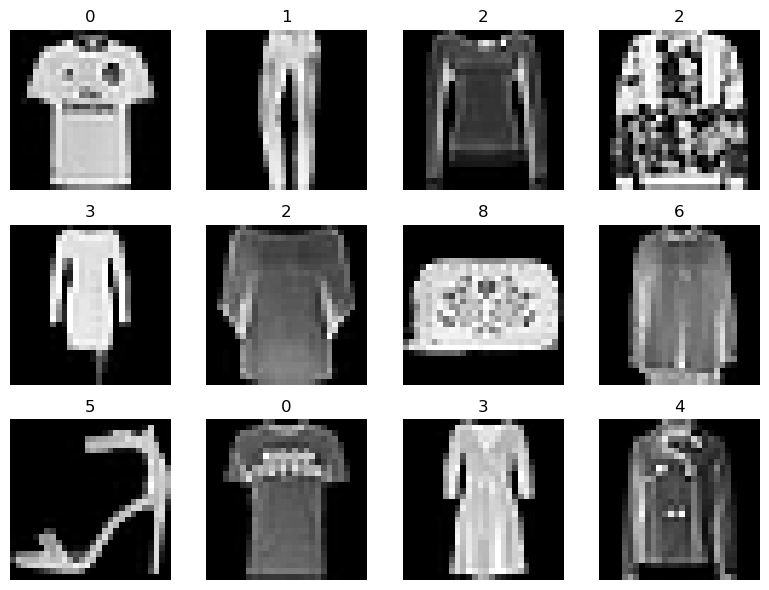

Saved sample image grid to: fashion-mnist_test_sample_images.png

--- Small demo classifier (SGDClassifier) ---
Fitting classifier (may take a few seconds)...
Demo classifier accuracy on test subset: 80.85%

Classification report (first labels):
              precision    recall  f1-score   support

           0      0.766     0.720     0.742       200
           1      0.969     0.945     0.957       200
           2      0.696     0.665     0.680       200
           3      0.736     0.865     0.795       200
           4      0.731     0.705     0.718       200
           5      0.909     0.900     0.905       200
           6      0.527     0.545     0.536       200
           7      0.893     0.875     0.884       200
           8      0.959     0.925     0.941       200
           9      0.922     0.940     0.931       200

    accuracy                          0.808      2000
   macro avg      0.811     0.809     0.809      2000
weighted avg      0.811     0.808     0.809      2

In [68]:
# ============================================================
# Single cell: Fashion-MNIST demo + Section 14 learning resources
# - Auto-detect csv (prefers fashion-mnist_test.csv if present)
# - Embedded text for 14.1 - 14.4
# - EDA, detect Fashion-MNIST layout (label + 784 pixels), show sample images
# - Train a small demo classifier on a sample subset (SGDClassifier)
# - Save cleaned CSV and sample image grid
# ============================================================

import os, warnings, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

print("=== Fashion-MNIST demo + Section 14 resources ===\n")

# -----------------------
# 0) Auto-detect CSV file
# -----------------------
preferred_name = "fashion-mnist_test.csv"
csv_files = [f for f in os.listdir() if f.lower().endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("No CSV files found in working directory. Upload 'fashion-mnist_test.csv' and re-run.")
if preferred_name in csv_files:
    fname = preferred_name
else:
    fname = csv_files[0]
print("Loading CSV:", fname)

# -----------------------
# 1) Load dataset (pandas)
# -----------------------
df = pd.read_csv(fname)
print("Loaded shape:", df.shape)
display(df.head())

# -----------------------
# 2) Embedded Section 14 documentation (printed)
# -----------------------
print("\n" + "="*70)
print("Section 14 — Learning resources (embedded)")
print("="*70 + "\n")
print("""14.1. The scikit-learn MOOC
- A free, community-maintained Massive Open Online Course covering core and advanced scikit-learn topics.
- Good for structured learning (lectures, quizzes, exercises). Search "scikit-learn MOOC" to find the official site and FUN platform mirror.

14.2. Videos
- scikit-learn maintainers and community post talks and tutorials on YouTube. Look for the scikit-learn channel and Inria Learning Lab playlists.

14.3. New to Scientific Python?
- Read the Python Scientific Lecture Notes to get comfortable with NumPy, Matplotlib and pandas.
- Strong NumPy fundamentals make working with scikit-learn far easier.

14.4. External Tutorials
- There are topic-specific tutorials (neuroimaging, astronomy, etc.). Search for "Machine Learning for <domain> in Python" to find domain-specific guides.
""")

# -----------------------
# 3) Quick EDA & format detection
# -----------------------
print("\n--- Quick EDA ---")
print("Columns:", list(df.columns[:12]) , " ...")
print("dtypes summary:")
display(df.dtypes.value_counts())

n_rows, n_cols = df.shape

# Common Fashion-MNIST CSV formats:
# - either: one 'label' column + 784 pixel columns named pixel0..pixel783 or 0..783
# - or: first column is labels, remaining are pixel columns with numeric names
colnames = [c.lower() for c in df.columns]
is_fashion_like = False
label_col = None

# heuristic: if any column name contains 'label' or first column looks like labels (small ints 0..9)
for c in df.columns:
    if "label" in c.lower():
        label_col = c
        break
if label_col is None:
    # assume first column is label if it has few unique integer values
    first_col = df.columns[0]
    if pd.api.types.is_integer_dtype(df[first_col]) or pd.api.types.is_float_dtype(df[first_col]):
        nunique = df[first_col].nunique()
        if nunique <= 20:
            label_col = first_col

if label_col is not None:
    # count candidate pixel columns
    pixel_cols = [c for c in df.columns if c != label_col]
    if len(pixel_cols) in (784, 28*28):
        is_fashion_like = True

print("Detected label column:", label_col)
print("Detected fashion-like layout (label + 784 pixels):", is_fashion_like)

# -----------------------
# 4) If fashion-like -> show sample images
# -----------------------
if is_fashion_like:
    print("\nShowing 12 sample images from dataset (first 12 rows)...")
    pixels = df.drop(columns=[label_col]).iloc[:12].values
    labels = df[label_col].iloc[:12].values
    # ensure pixels are 0..255 numeric
    pixels = np.asarray(pixels, dtype=float)
    if pixels.max() <= 1.0:
        pixels = pixels * 255.0
    # plot 3x4 grid
    fig, axes = plt.subplots(3,4, figsize=(8,6))
    for i, ax in enumerate(axes.ravel()):
        if i >= pixels.shape[0]:
            ax.axis("off"); continue
        img = pixels[i].reshape(28,28)
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax.set_title(str(labels[i]))
        ax.axis("off")
    plt.tight_layout()
    sample_img_name = os.path.splitext(fname)[0] + "_sample_images.png"
    plt.savefig(sample_img_name, dpi=150)
    plt.show()
    print("Saved sample image grid to:", sample_img_name)
else:
    print("\nData does not match label+784-pixels heuristic; showing first 6 rows above for inspection.")

# -----------------------
# 5) Small demo classifier (safe: small subset)
# -----------------------
print("\n--- Small demo classifier (SGDClassifier) ---")
if label_col is None:
    print("No label column detected: skipping supervised demo.")
else:
    # Prepare X, y
    X = df.drop(columns=[label_col]).values
    y = df[label_col].values
    # If pixel values are string/object attempt conversion
    X = np.asarray(X, dtype=float)
    # scale features for SGD
    # sample a subset for speed (max 10k rows)
    max_rows = 10000
    if X.shape[0] > max_rows:
        print(f"Dataset has {X.shape[0]} rows — sampling {max_rows} for demo.")
        idx = np.random.RandomState(0).choice(X.shape[0], max_rows, replace=False)
        X_sub = X[idx]
        y_sub = y[idx]
    else:
        X_sub = X
        y_sub = y

    # train/test split and pipeline
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub if len(np.unique(y_sub))>1 else None)
    clf = Pipeline([("scale", StandardScaler()), ("sgd", SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42))])
    print("Fitting classifier (may take a few seconds)...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Demo classifier accuracy on test subset: {acc*100:.2f}%")
    print("\nClassification report (first labels):")
    try:
        print(classification_report(y_test, y_pred, digits=3))
    except Exception:
        pass

# -----------------------
# 6) Save cleaned CSV and small sample
# -----------------------
print("\nSaving artifacts...")
cleaned_name = os.path.splitext(fname)[0] + "_cleaned.csv"
df_clean = df.copy()
# fill numeric NaNs with 0 (safe for image pixels) and forward-fill text
for c in df_clean.columns:
    if pd.api.types.is_numeric_dtype(df_clean[c]):
        df_clean[c] = df_clean[c].fillna(0)
    else:
        df_clean[c] = df_clean[c].fillna(method="ffill").fillna("")
df_clean.to_csv(cleaned_name, index=False)
print("Saved cleaned CSV:", cleaned_name)

sample_name = os.path.splitext(fname)[0] + "_small_sample.csv"
df.head(200).to_csv(sample_name, index=False)
print("Saved small sample (first 200 rows):", sample_name)

print("\nDone. Notes:")
print("- Section 14 resources are printed above; visit the scikit-learn MOOC and Python Scientific Lecture Notes for guided learning.")
print("- If you'd like, I can now: (1) run a full CV baseline across models, (2) produce class-probability visualizations, or (3) prepare a separate notebook with markdown explaining Section 14 with links.")
